## Import

In [105]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# noisy
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino, FakeAlmadenV2, FakeManilaV2, FakeJakartaV2, FakeGuadalupeV2
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2



## Generazione dei dati per assets fintizzi

Per la generazione di un numero di asset (`assets`) fintizzi abbiamo utilizzato la classe `RandomDataProvider`, utilizzando il seed di generazione (`seed`) 1659, per un periodo di analisi dal 1 gennaio 2016 (`start_date`) al 1 gennaio 2020 (`end_date`).

I dati generati sono raggruppati sotto dei ticker, identificati unicamente dalla stringa `TICKER_{i}`, dove `i` è un numero intero che va da 0 a numero di `assets - 1`.

In [106]:
assets = 8
n_repeats = 50
seed = 1659

start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

# Generiamo i dati
tickers = [f"TICKER_{i}" for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=tickers,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
stock_data = data_provider._data

dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

## Stampa dei risultati

In [107]:
def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Stampa dei dati generati

In [108]:
# Funzione per stampare la tabella
def print_table(stock_data, tickers, dates):
    print(f"\n{'Dati Generati per il periodo dal':<12} {dates[0].date()} al {dates[-1].date()}:")
    print("-" * 80)
    print(f"{'Data':<12}", end="")
    for ticker in tickers:
        print(f"{ticker:<12}", end="")
    print()
    print("-" * 80)

    for i, date in enumerate(dates):
        print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
        for j in range(len(stock_data)):
            print(f"{stock_data[j][i]:<12.4f}", end="")
        print()
    print("-" * 80)

# print_table(stock_data, tickers, dates)

## Funzione per generare i grafici dei prezzi degli assets (mpl)

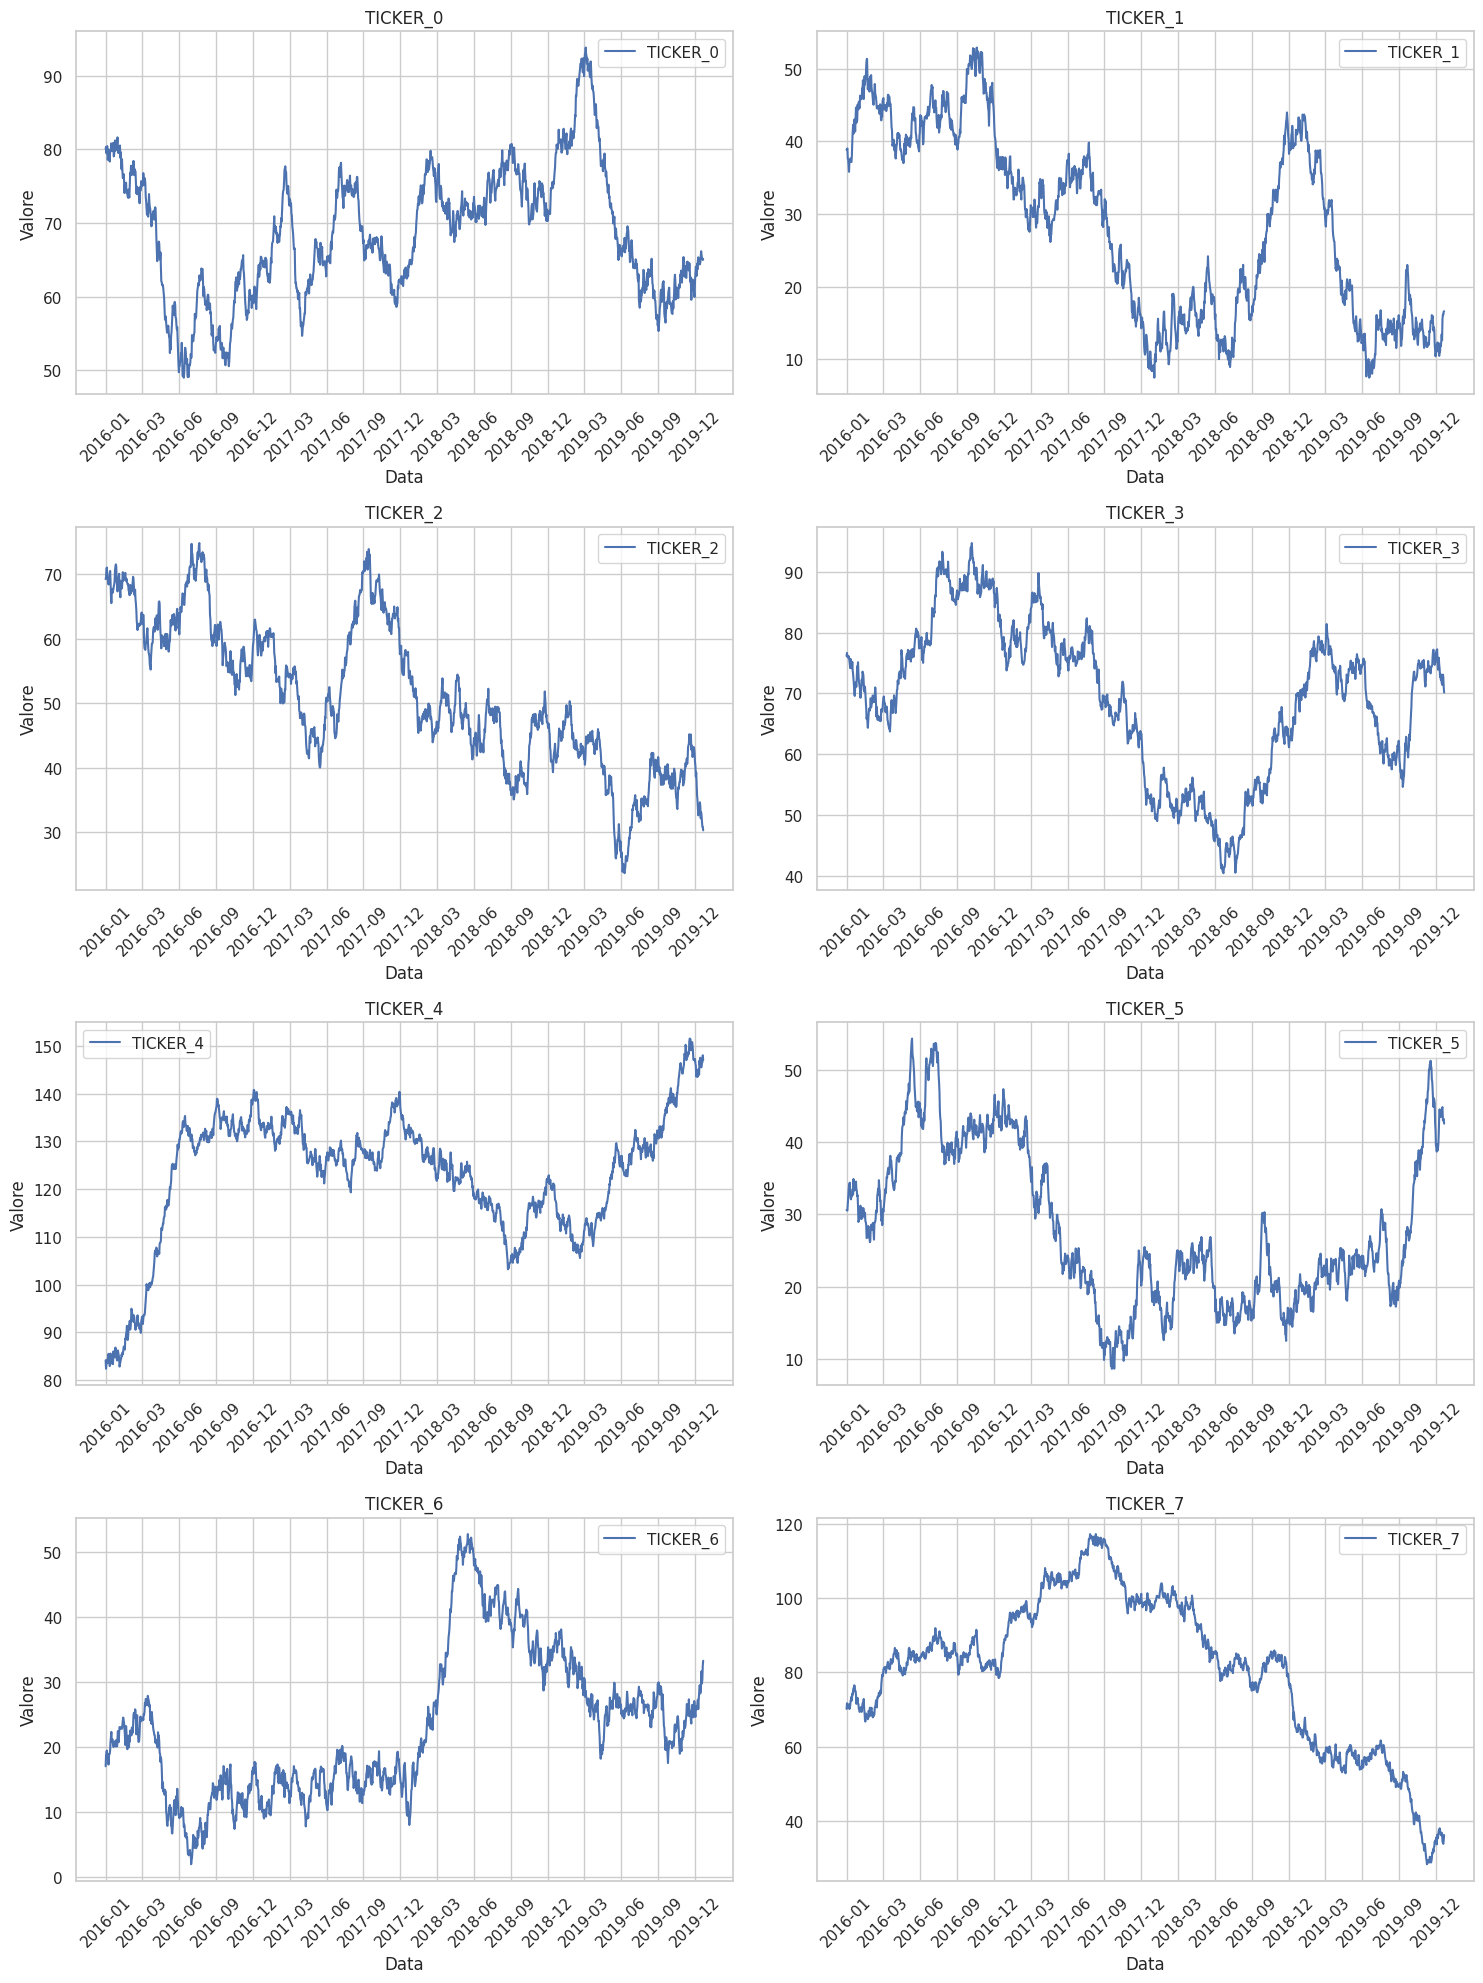

In [109]:
# Funzione per creare i grafici
def create_ticker_plots(stock_data, tickers, dates):
    num_tickers = len(tickers)
    cols = 2  # Numero di colonne nella griglia
    rows = (num_tickers + cols - 1) // cols  # Calcola il numero di righe

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_1d(axes).flatten()  # Assicura che sia un array piatto

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ax.plot(dates, stock_data[i], label=ticker)
        ax.set_title(ticker)
        ax.set_xlabel("Data")
        ax.set_ylabel("Valore")

        # Mostra solo i mesi sull'asse x
        ax.set_xticks(dates[::90])  # Ogni 90 giorni (circa un trimestre)
        ax.set_xticklabels([date.strftime('%Y-%m') for date in dates[::90]], rotation=45)
        ax.legend()

    # Rimuovi eventuali subplot vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_ticker_plots(stock_data, tickers, dates)

## Funzione per generare i grafici dei prezzi degli assets (seaborn)

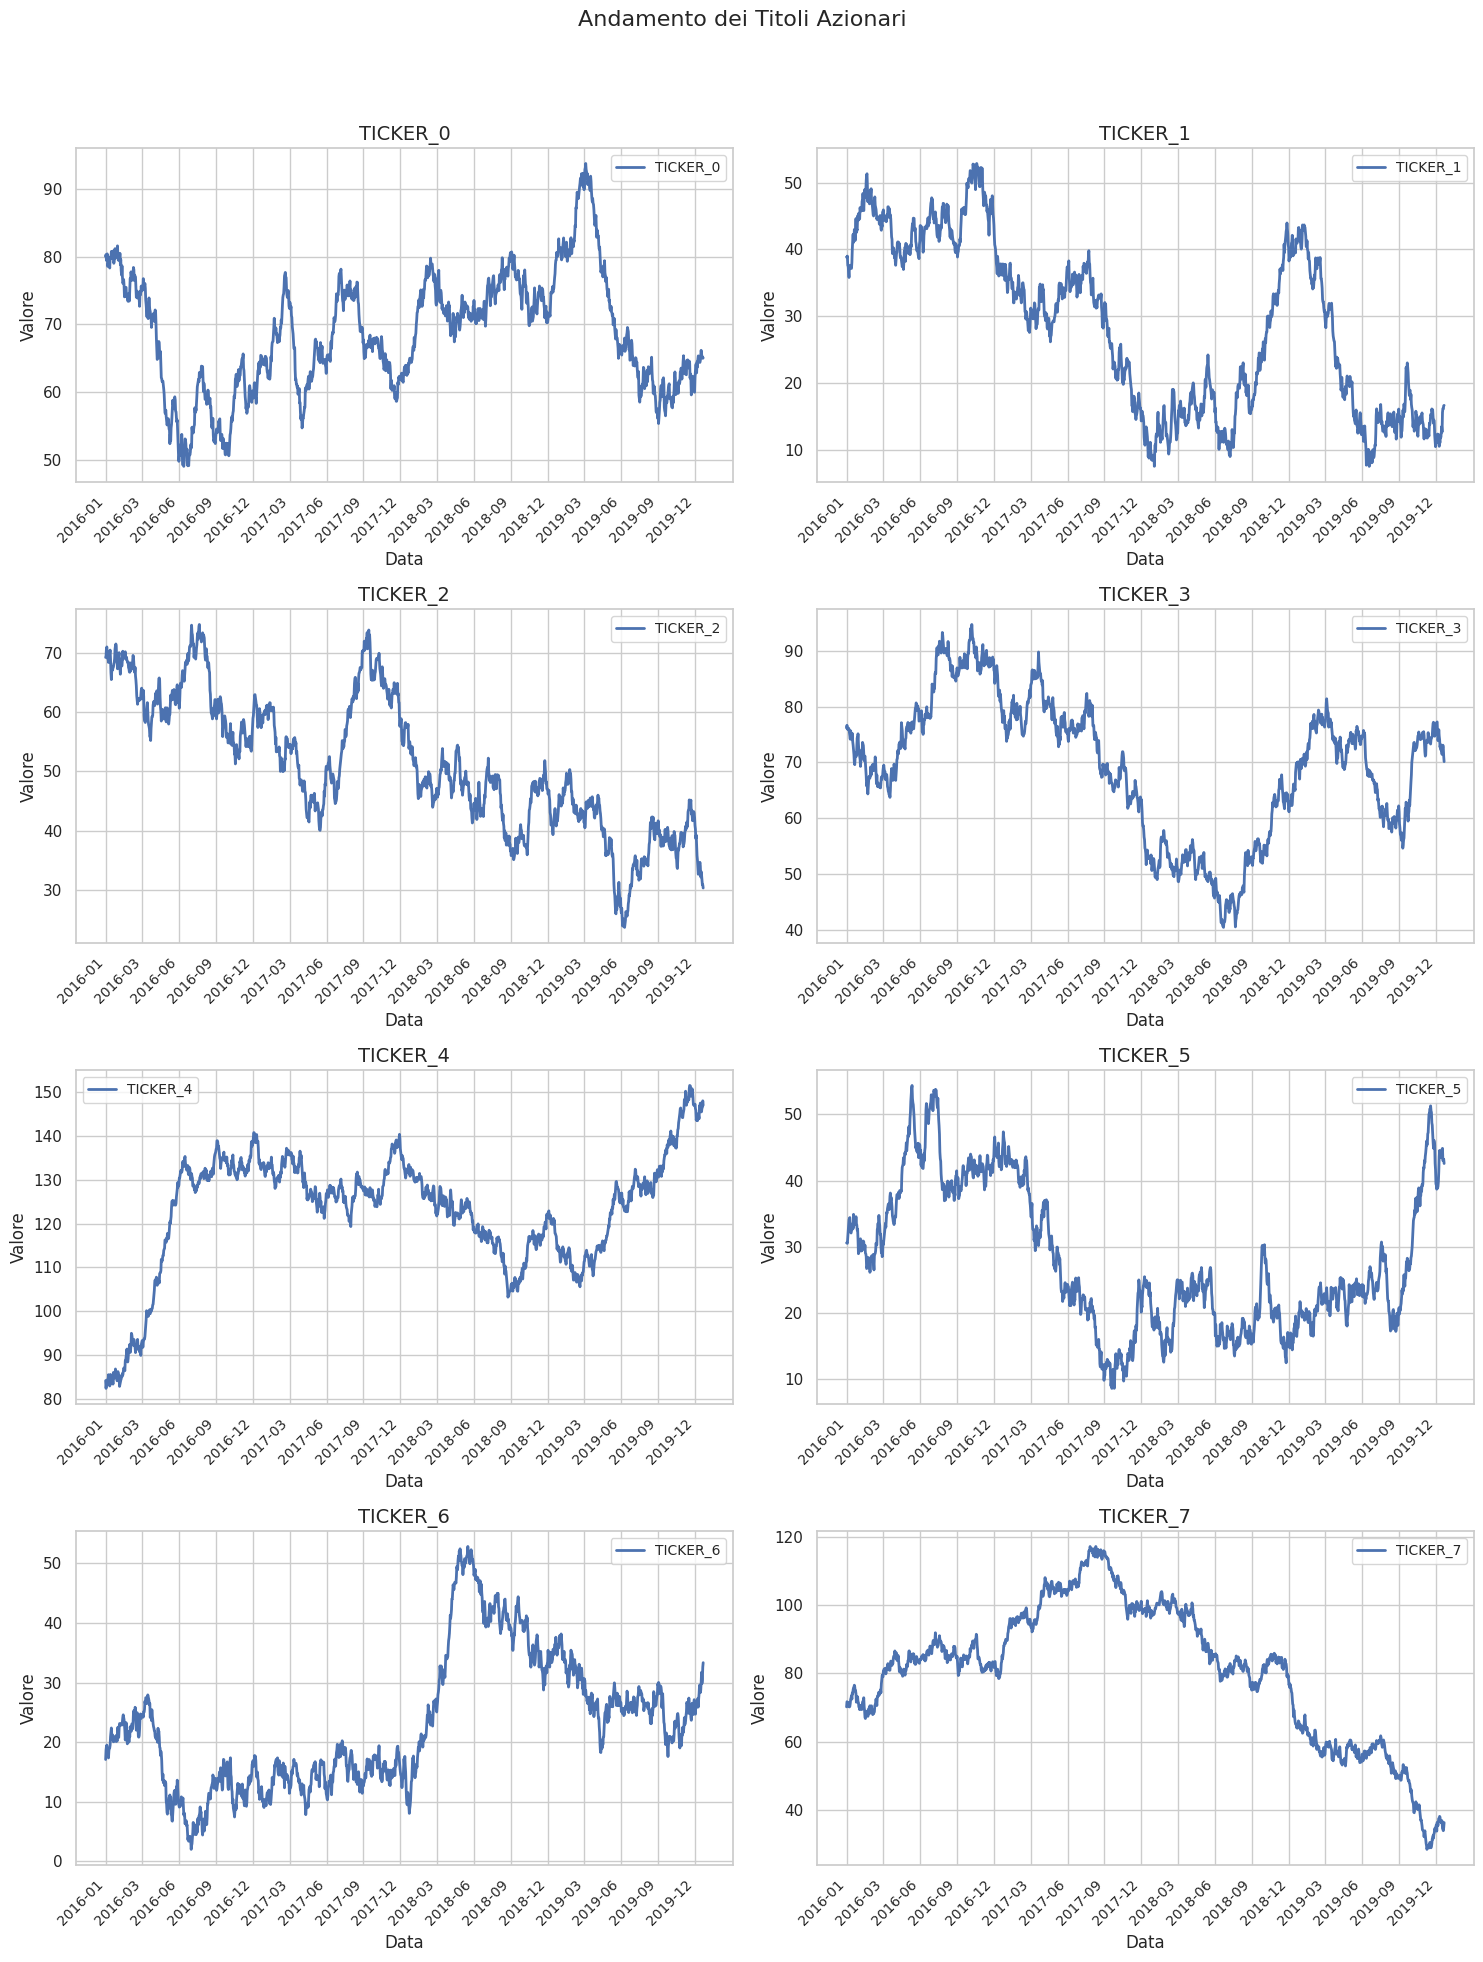

In [110]:
def create_ticker_plots_seaborn(stock_data, tickers, dates):
    sns.set_theme(style="whitegrid")  # Tema estetico di Seaborn
    num_tickers = len(tickers)
    cols = 2  # Numero di colonne nella griglia
    rows = (num_tickers + cols - 1) // cols  # Calcola il numero di righe

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_1d(axes).flatten()  # Assicura che sia un array piatto

    # Converte le date in un DataFrame per Seaborn
    date_series = pd.to_datetime(dates)  # Conversione a formato pandas datetime

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        data_df = pd.DataFrame({"Data": date_series, "Valore": stock_data[i]})
        
        # Plot con Seaborn
        sns.lineplot(
            data=data_df, 
            x="Data", 
            y="Valore", 
            ax=ax, 
            label=ticker, 
            linewidth=2.0
        )
        
        ax.set_title(ticker, fontsize=14)
        ax.set_xlabel("Data", fontsize=12)
        ax.set_ylabel("Valore", fontsize=12)

        # Etichette
        ax.set_xticks(date_series[::90])  # Mostra ogni 90 giorni
        ax.set_xticklabels(
            [date.strftime('%Y-%m') for date in date_series[::90]], 
            rotation=45, 
            ha='right', 
            fontsize=10
        )
        ax.legend(fontsize=10)

    # Rimuove subplot vuoti
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Titolo globale
    fig.suptitle("Andamento dei Titoli Azionari", fontsize=16)
    
    # Ottimizzazione layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig("ticker_plots_seaborn.png", dpi=300)
    plt.show()

create_ticker_plots_seaborn(stock_data, tickers, dates)


## Matrice di covarianza degli assets

In questa cella, eseguiamo i seguenti passaggi:
1. Calcoliamo il vettore medio dei rendimenti periodici (`mu`) utilizzando il metodo `get_period_return_mean_vector` del `data_provider`.
2. Calcoliamo la matrice di covarianza dei rendimenti periodici (`sigma`) utilizzando il metodo `get_period_return_covariance_matrix` del `data_provider`.
3. Creiamo un DataFrame Pandas (`sigma_df`) per la matrice di covarianza, utilizzando i ticker degli asset come indici e colonne.
4. Visualizziamo la matrice di covarianza degli asset utilizzando una heatmap di Seaborn:
   - Impostiamo la dimensione della figura a 8x6 pollici.
   - Utilizziamo `sns.heatmap` per creare la heatmap, con annotazioni dei valori, formato dei numeri a 4 cifre decimali, mappa di colori "coolwarm", barra dei colori, larghezza delle linee di 0.5 e celle quadrate.
   - Impostiamo il titolo della heatmap a "Matrice di covarianza degli assets".
5. Mostriamo la heatmap con `plt.show()`.

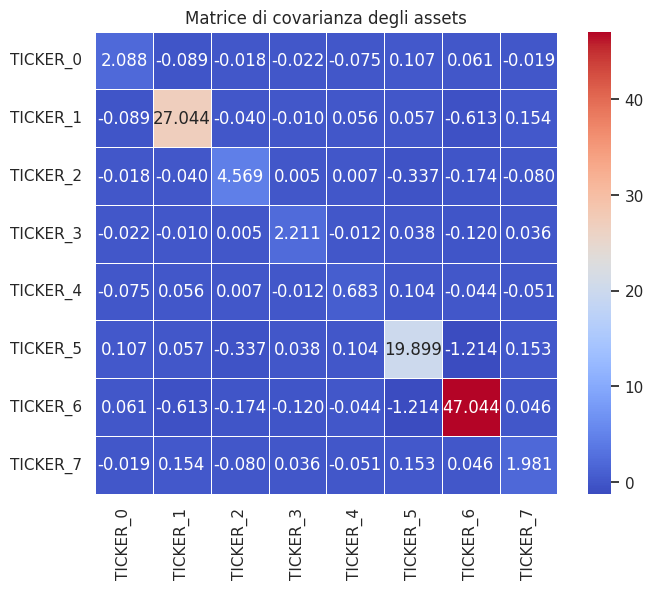

In [111]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()


# TODO i valori sono bassisimi e la matrice non rende, dobbiamo tipo moltiplicare tutti i valori per 1000 cosi si visualizzano meglio i dati
sigma *= 10000 # ! soluzione temporanea

sigma_df = pd.DataFrame(sigma, index=tickers, columns=tickers)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

sigma /= 10000 # ! soluzione temporanea

## Configurazione del problema

In questa cella, eseguiamo i seguenti passaggi:

1. Impostiamo il fattore di rischio (`risk_factor`) al valore di 0.2.
2. Definiamo il budget come la metà del numero totale di asset (`assets // 2`), il che significa che selezioneremo il 50% degli asset.
3. Inizializziamo un'istanza di `PortfolioOptimization` con i seguenti parametri:
   - `expected_returns`: il vettore dei rendimenti attesi (`mu`).
   - `covariances`: la matrice di covarianza dei rendimenti (`sigma`).
   - `risk_factor`: il fattore di rischio impostato a 0.2.
   - `budget`: il budget impostato a metà del numero totale di asset.
4. Convertiamo il problema di ottimizzazione del portafoglio in un programma quadratico (`qp`) utilizzando il metodo `to_quadratic_program` dell'istanza `PortfolioOptimization`.

In [112]:
risk_factor = 0.3
# budget = assets // 2 # 50% of the assets
budget = int(assets / 3 * 2)
penalty = budget 
print(f"Assets: {assets}, Budget: {budget}, Penalty: {penalty}, Risk: {risk_factor}, Num Repeats: {n_repeats}")

po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()

Assets: 8, Budget: 5, Penalty: 5, Risk: 0.3, Num Repeats: 50


## Configurazione degli algoritmi

In questa cella, configuriamo e inizializziamo gli algoritmi di ottimizzazione del portafoglio che verranno utilizzati per risolvere il problema:

1. **Variabili comuni**:
   - Impostiamo il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Configuriamo l'ottimizzatore `COBYLA` con un numero massimo di iterazioni (`maxiter`) pari a 1000.

2. **Classical**:
   - Inizializziamo l'ottimizzatore classico `Exact Eigensolver` utilizzando `NumPyMinimumEigensolver` e `MinimumEigenOptimizer`.

3. **VQE**:
   - Configuriamo l'ansatz `TwoLocal` con rotazioni `ry` e gate `cz`, con entanglement completo e barriere inserite.
   - Inizializziamo `SamplingVQE` con il campionatore `Sampler`, l'ansatz configurato e l'ottimizzatore `COBYLA`.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `SamplingVQE`.

4. **QAOA**:
   - Impostiamo nuovamente il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Inizializziamo `QAOA` con il campionatore `Sampler`, l'ottimizzatore `COBYLA` e un numero di ripetizioni (`reps`) pari a 1.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `QAOA`.

In [113]:

# Variabili comuni per VQE e QAOA
algorithm_globals.random_seed = seed
cobyla = COBYLA()
iter = 250
cobyla.set_options(maxiter=iter)

# doc: https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2
backend = GenericBackendV2(num_qubits=assets, 
                           noise_info=True,
                           seed=seed,
                           calibrate_instructions=True)

# Crea un modello di rumore personalizzato
noise_model = NoiseModel()

# Definisci gli errori di depolarizzazione e rilassamento termico
depol_error_1q = depolarizing_error(0.01, 1)  # Errore di depolarizzazione per gate a 1 qubit
depol_error_2q = depolarizing_error(0.02, 2)  # Errore di depolarizzazione per gate a 2 qubit
thermal_relaxation_error_1q = thermal_relaxation_error(50, 70, 0.1)  # Errore di rilassamento termico per gate a 1 qubit

thermal_relaxation_error_2q = thermal_relaxation_error_1q.tensor(thermal_relaxation_error_1q)
thermal_relaxation_error_3q = thermal_relaxation_error_1q.tensor(thermal_relaxation_error_1q).tensor(thermal_relaxation_error_1q)

# Aggiungi gli errori ai gate specifici
noise_model.add_all_qubit_quantum_error(depol_error_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depol_error_2q, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_2q, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_3q, ['ccx'])

# Definisci un errore di lettura
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])
noise_model.add_all_qubit_readout_error(readout_error)

# noise_model = NoiseModel.from_backend(backend)
simulator = AerSimulator(noise_model=noise_model)

print(backend.description)
print(noise_model)

This is a device with 8 qubits and generic settings.
NoiseModel:
  Basis gates: ['ccx', 'cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'ccx', 'measure', 'u2', 'u3', 'cx']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx', 'ccx', 'measure']


### Classico

In [114]:
# Classico
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result_exact = exact_eigensolver.solve(qp)
print_result(result_exact, po)

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0024

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 1 1 1 0]	-0.0024		1.0000


### VQE noiseless

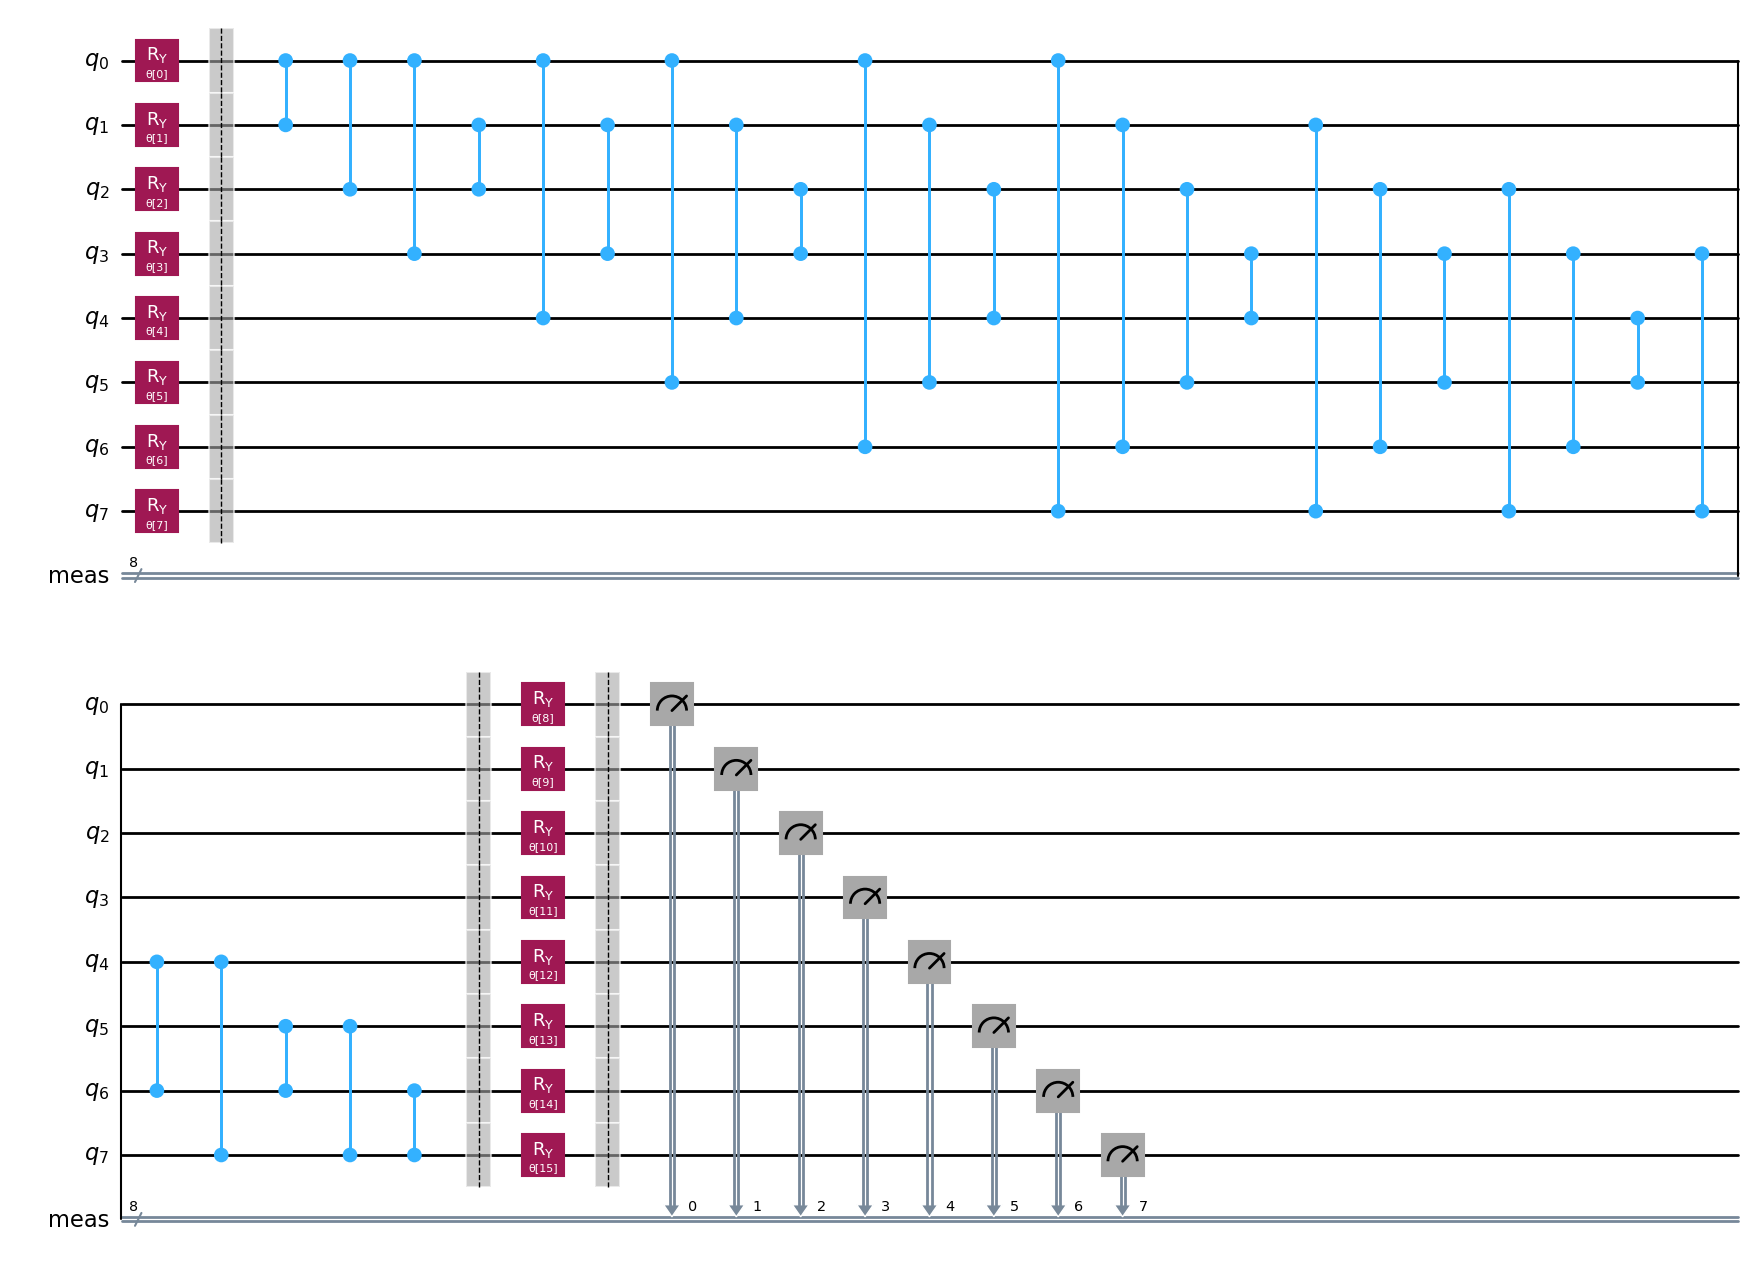

In [115]:
# VQE
ry = TwoLocal(
    num_qubits=assets,
    rotation_blocks="ry",
    entanglement_blocks="cz",
    reps=1,
    entanglement="full",
    insert_barriers=True
)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes, penalty)
result_svqe = svqe.solve(qp)

# print_result(result_svqe, po)

ry_decomposed = ry.decompose()
ry_decomposed.draw("mpl")

### VQE noisy

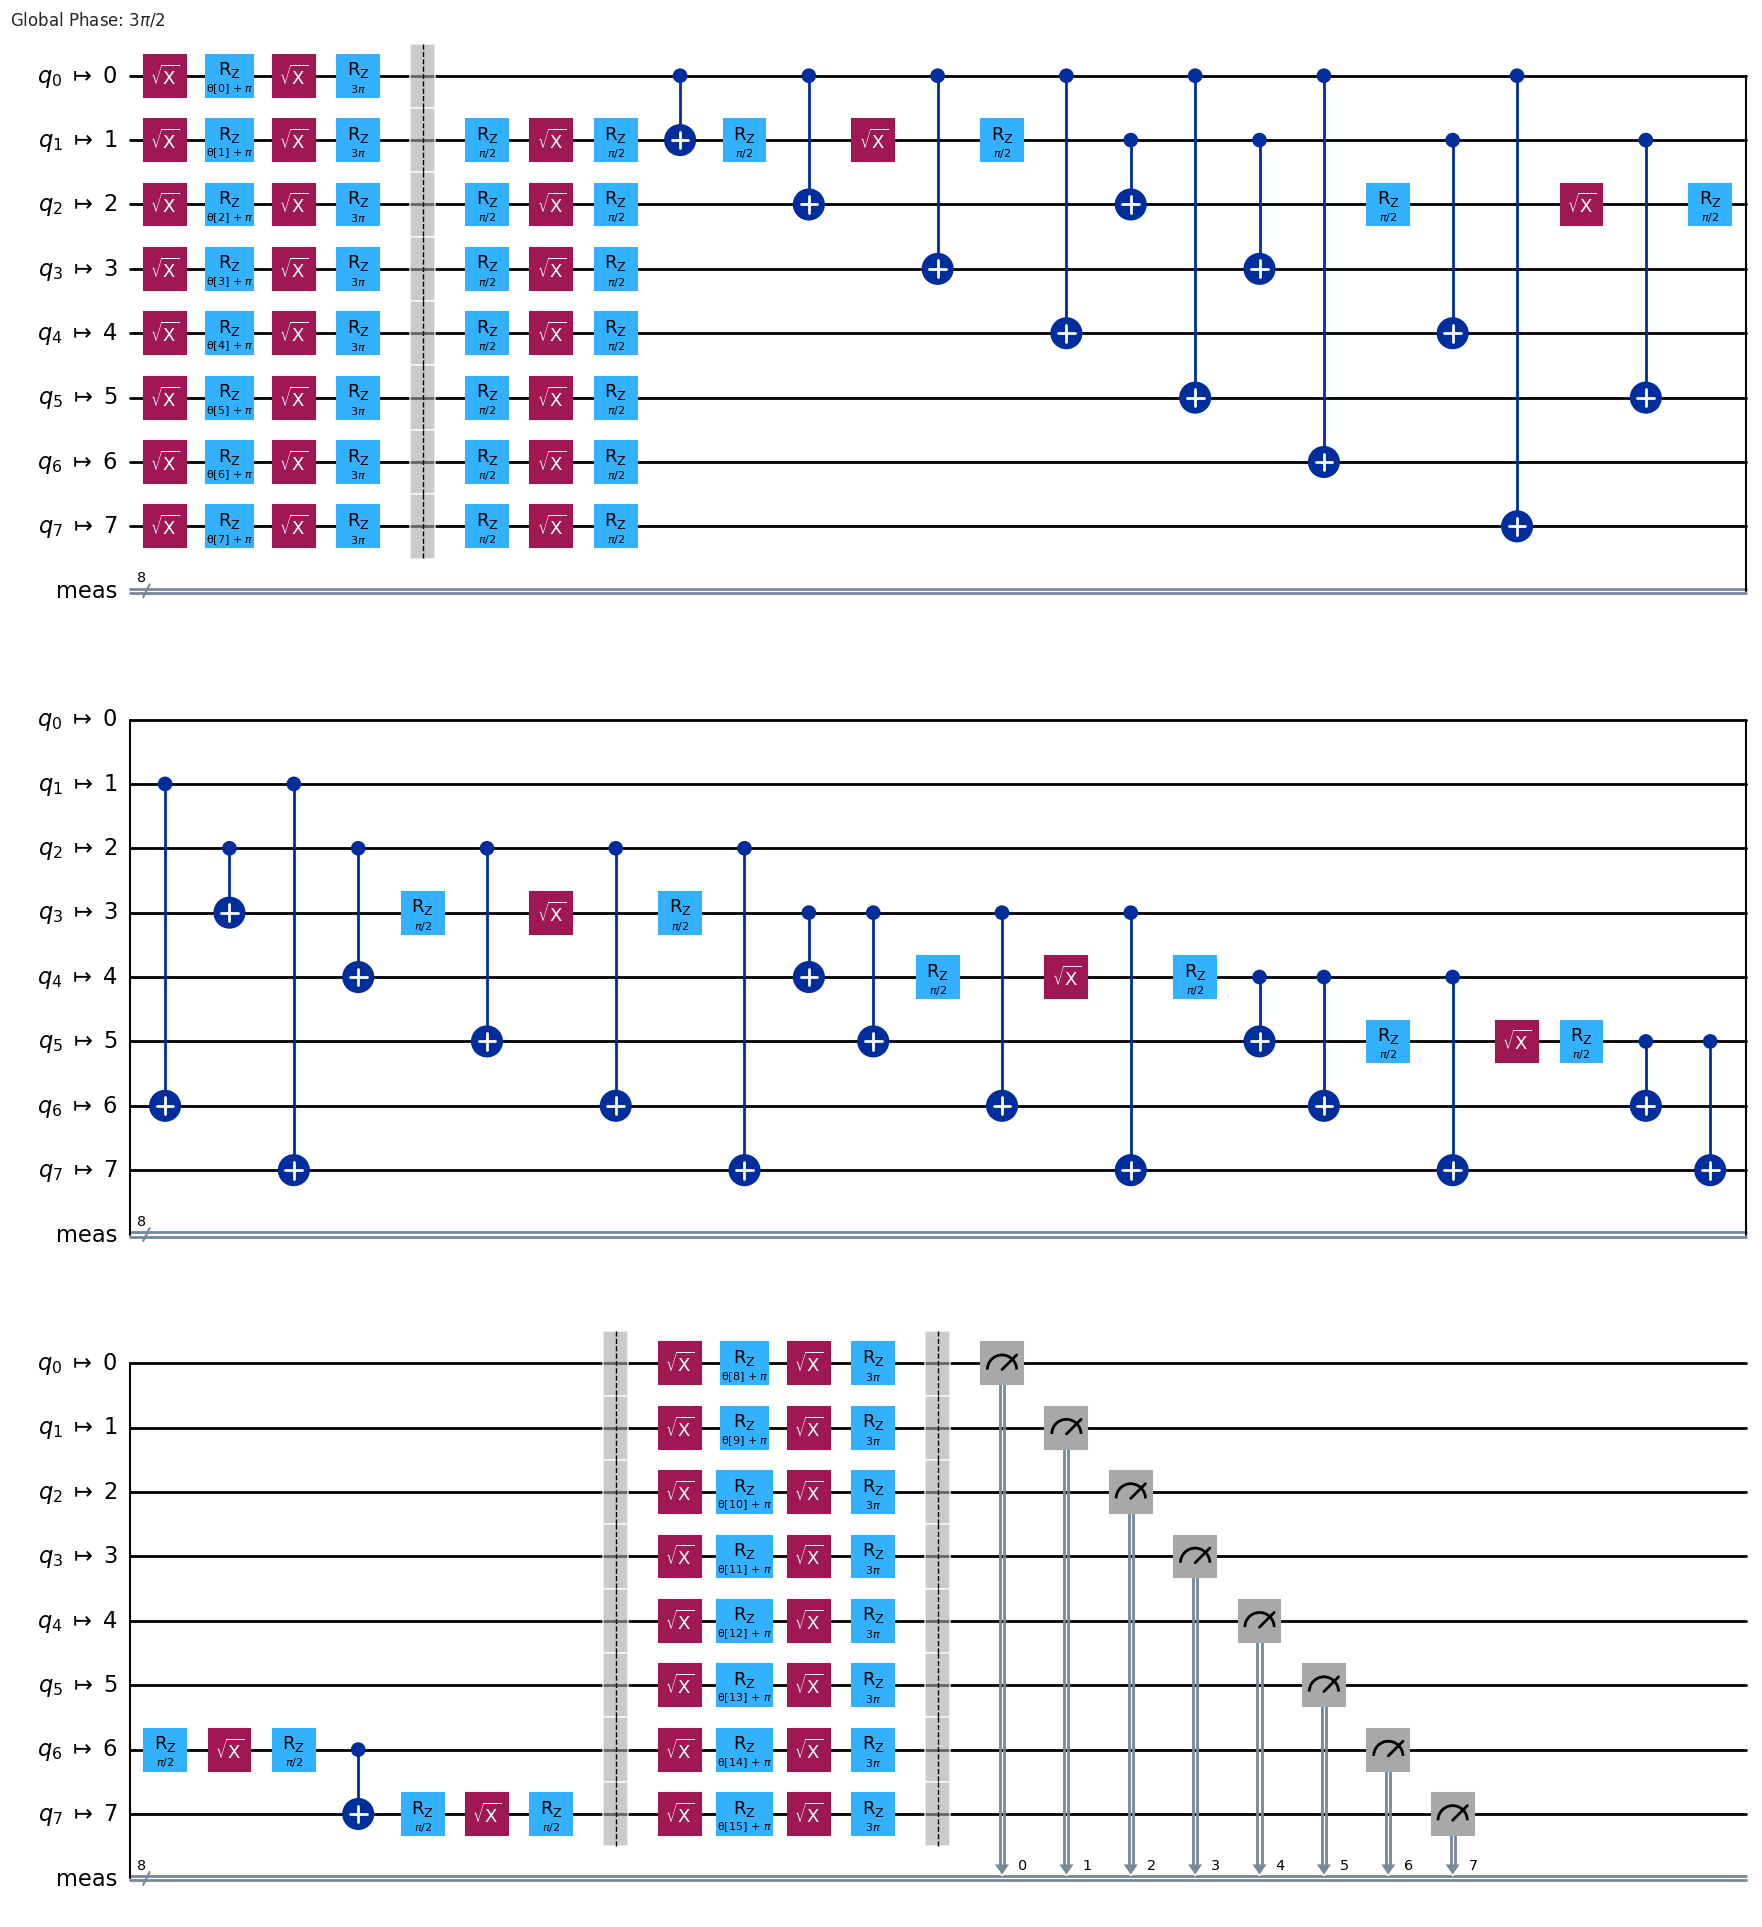

In [116]:
ansatz = TwoLocal(
    num_qubits=assets,
    rotation_blocks="ry",
    entanglement_blocks="cz",
    reps=1,
    entanglement="full",
    insert_barriers=True
)

decomposed_ansatz = ansatz.decompose()
# decomposed_ansatz.draw("mpl")
transpiled_ansatz = transpile(decomposed_ansatz, backend=backend)

svqe_mes_noisy = SamplingVQE(sampler=Sampler(), ansatz=transpiled_ansatz, optimizer=cobyla)

svqe_noisy = MinimumEigenOptimizer(svqe_mes_noisy, penalty)
result_svqe_noisy = svqe_noisy.solve(qp)

transpiled_ansatz.draw("mpl")


### QAOA noiseless

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0024

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 1 0 0 1 1]	-0.0009		0.0107
[0 1 0 0 0 1 1 1]	-0.0016		0.0098
[0 1 1 1 0 1 0 0]	-0.0001		0.0088
[1 0 0 0 1 0 1 0]	-0.0017		0.0088
[0 0 0 0 0 0 1 1]	-0.0010		0.0088
[0 1 1 0 1 1 0 0]	-0.0005		0.0088
[0 0 1 0 0 1 0 0]	-0.0002		0.0088
[0 1 1 1 1 0 0 0]	0.0001		0.0088
[1 0 1 1 0 1 0 0]	-0.0001		0.0088
[1 1 1 0 0 0 0 1]	0.0010		0.0088
[1 1 1 1 0 0 1 1]	-0.0004		0.0078
[1 1 0 0 1 0 1 0]	-0.0017		0.0078
[1 1 0 1 1 0 0 0]	-0.0002		0.0078
[1 1 1 0 1 0 1 1]	-0.0008		0.0078
[1 0 0 1 0 1 1 0]	-0.0020		0.0078
[1 0 0 0 0 0 0 1]	0.0005		0.0078
[1 0 0 1 1 0 0 1]	0.0001		0.0078
[0 1 1 0 1 0 1 0]	-0.0013		0.0068
[1 1 1 0 1 1 0 0]	-0.0004		0.0068
[1 0 0 1 0 1 0 1]	-0.0001		0.0068
[0 1 0 1 0 0 1 1]	-0.0009		0.0068
[1 0 0 1 1 1 1 1]	-0.0019		0.0068
[0 1 1 0 0 0 0 0]	0.0005		0.0068
[1 1 0 0 0 1 0 1]	-0.0000		0.

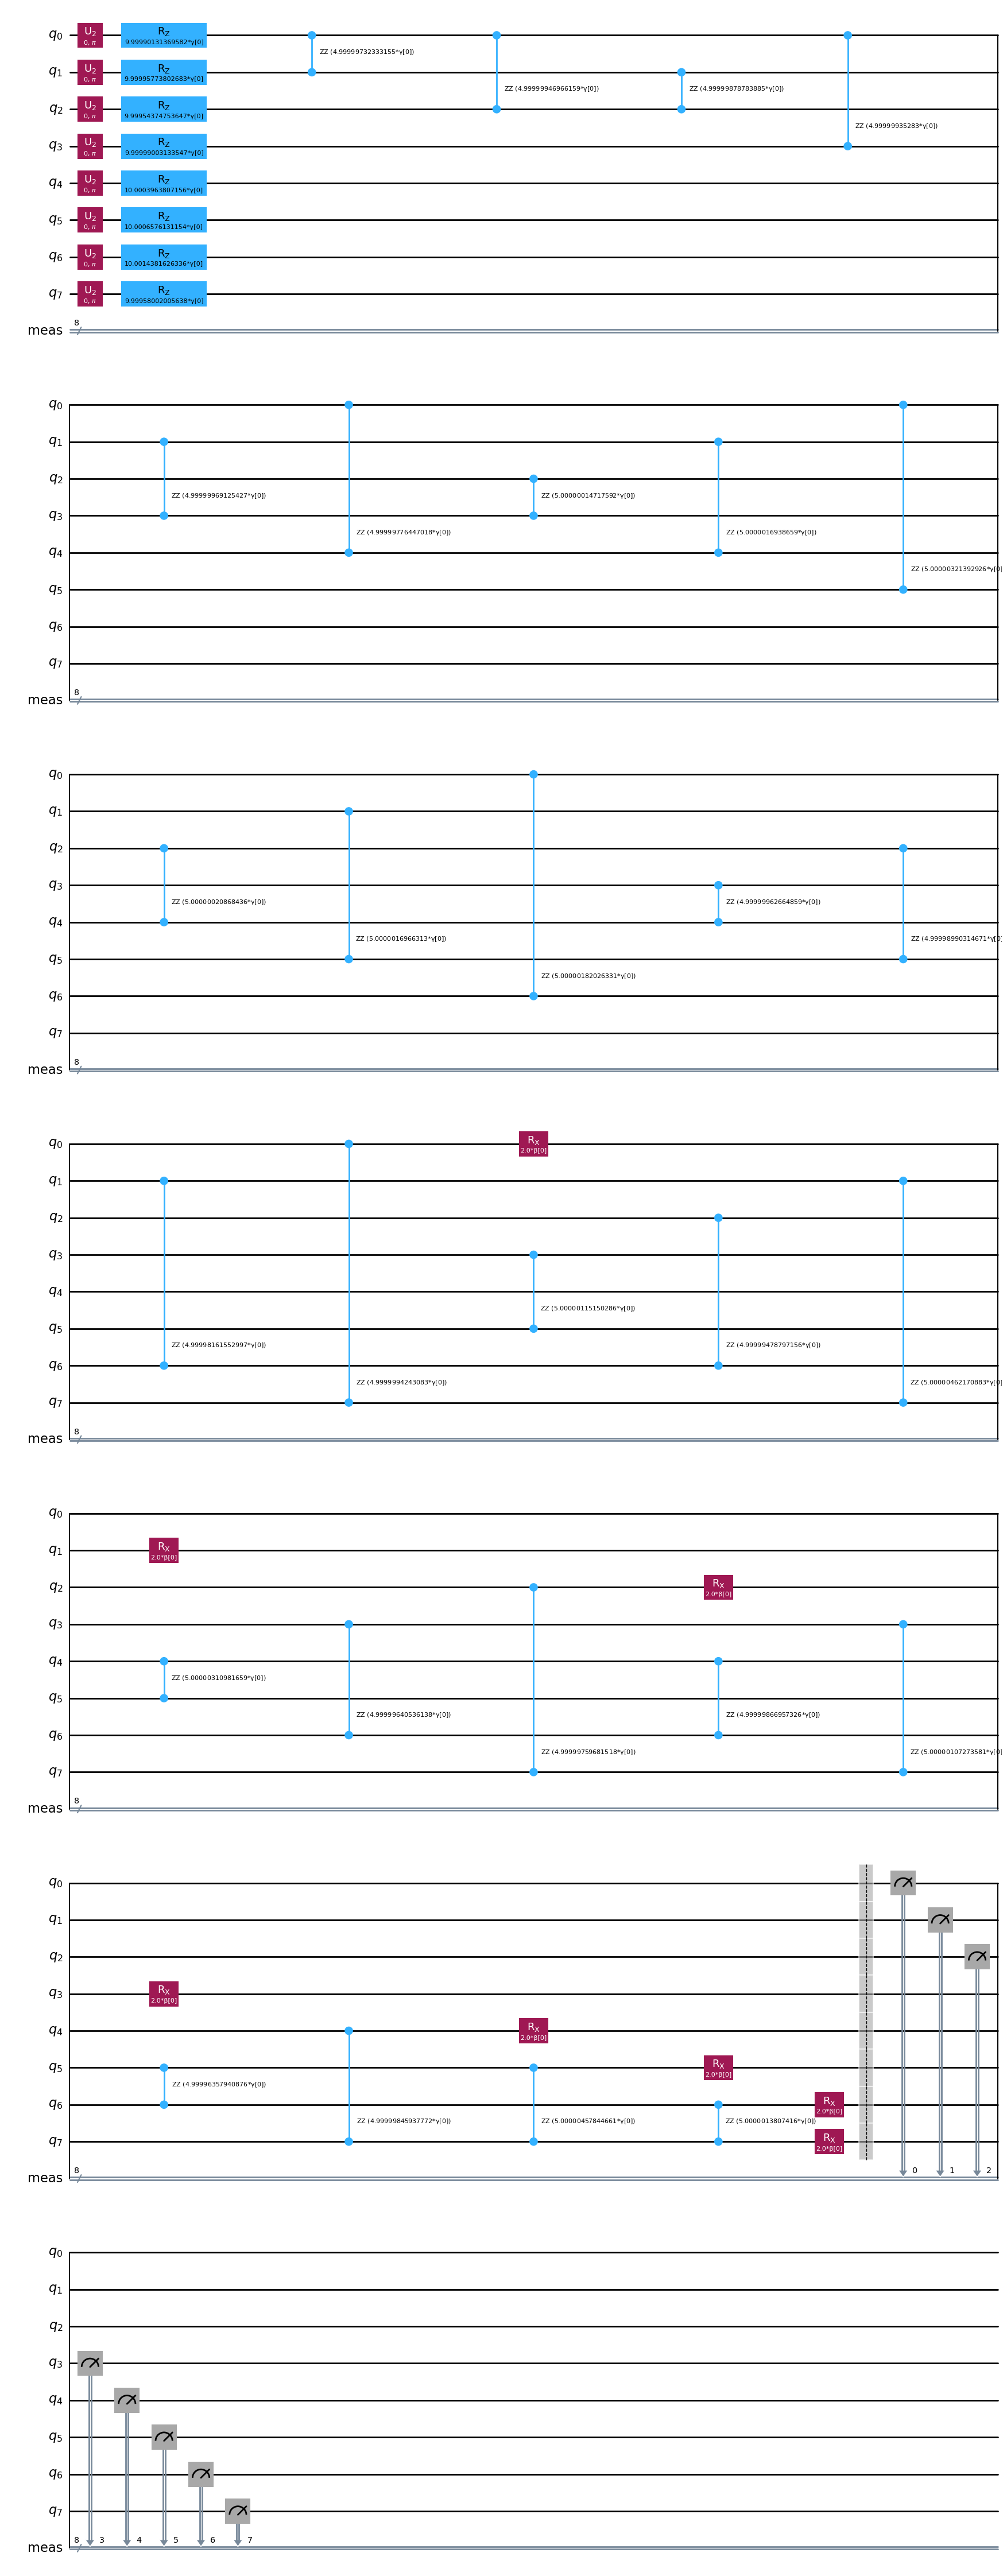

In [117]:
# QAOA
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
result = qaoa.solve(qp)

decomposed_circuit = qaoa_mes.ansatz.decompose()
print_result(result, po)
decomposed_circuit.draw("mpl") # print del circuito

## QAOA noisy

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0024

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 1 1 1 1]	-0.0015		0.0166
[1 1 0 1 0 1 1 1]	-0.0015		0.0137
[1 1 0 0 1 1 1 1]	-0.0019		0.0117
[0 0 1 1 1 1 0 1]	-0.0001		0.0117
[1 1 0 1 1 1 1 1]	-0.0019		0.0107
[1 1 1 0 1 0 1 1]	-0.0008		0.0107
[1 1 0 1 1 0 1 0]	-0.0017		0.0107
[1 1 1 1 0 1 0 1]	0.0004		0.0107
[1 1 0 1 1 1 0 1]	-0.0004		0.0107
[0 1 1 1 1 1 1 1]	-0.0016		0.0107
[0 1 1 1 1 0 1 0]	-0.0013		0.0107
[0 1 1 0 1 1 0 1]	-0.0001		0.0098
[1 1 1 0 1 1 1 0]	-0.0019		0.0098
[0 1 1 0 1 1 1 1]	-0.0016		0.0098
[0 1 1 1 0 1 1 1]	-0.0012		0.0098
[1 0 0 1 1 1 1 0]	-0.0024		0.0098
[1 1 0 1 1 1 1 0]	-0.0023		0.0098
[0 0 0 1 1 1 1 1]	-0.0020		0.0098
[0 1 1 1 1 0 1 1]	-0.0009		0.0088
[0 1 1 1 1 1 1 0]	-0.0020		0.0088
[0 1 0 1 1 1 1 1]	-0.0020		0.0088
[0 0 0 1 0 1 1 1]	-0.0016		0.0088
[1 1 1 0 0 1 0 1]	0.0004		0.0088
[1 1 1 1 1 1 1 0]	-0.0019	

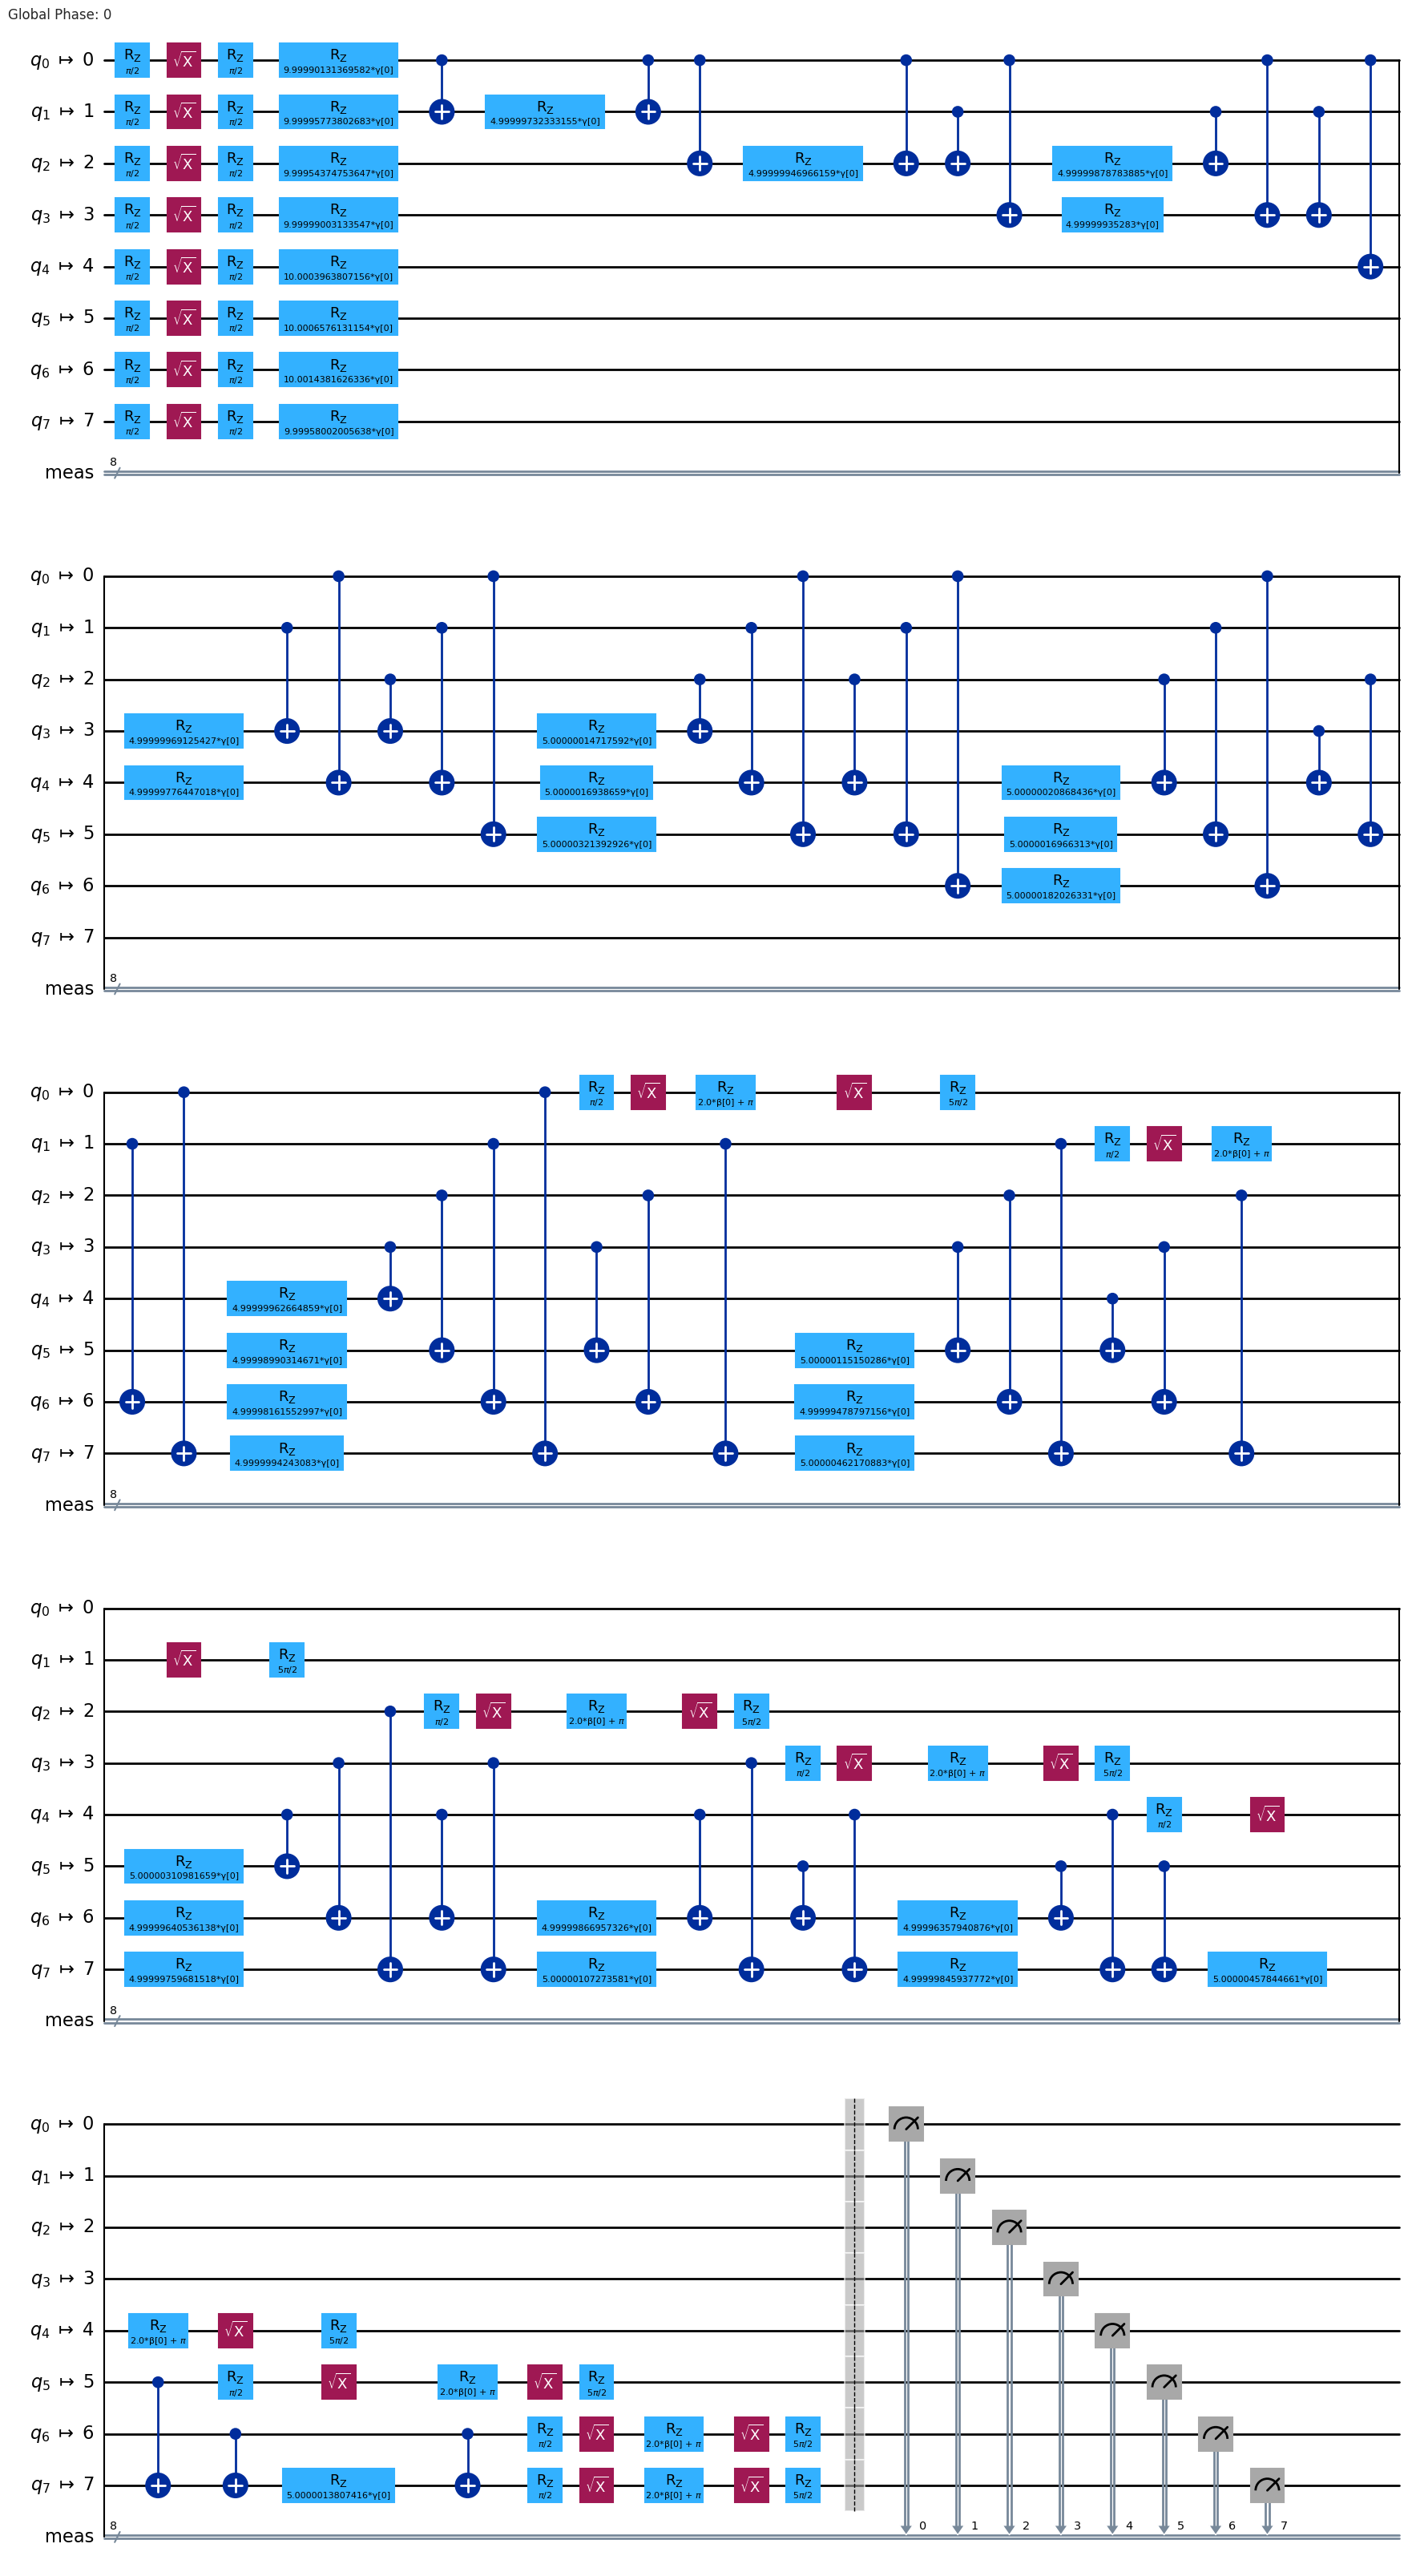

In [118]:
# QAOA noisy
qaoa_mes_noisy = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa_noisy = MinimumEigenOptimizer(qaoa_mes_noisy, penalty)
_ = qaoa_noisy.solve(qp)


decomposed_circuit_noisy = qaoa_mes_noisy.ansatz.decompose()
transpiled_circuit_noisy = transpile(decomposed_circuit_noisy, backend=backend)

qaoa_mes_noisy.ansatz = transpiled_circuit_noisy
# qaoa_noisy = MinimumEigenOptimizer(qaoa_mes_noisy, penalty)
result_decomposed = qaoa_noisy.solve(qp)
print_result(result_decomposed, po)
transpiled_circuit_noisy.draw("mpl") # print del circuito


### QAOA noiseless (versione non ottimizzata)

In [119]:
# Definizione dei parametri
num_assets = assets  # Esempio con 4 asset
p = 20 * num_assets 

# Creazione dei parametri per beta e gamma
beta = Parameter('beta')
gamma = Parameter('gamma')

# Creazione del circuito per lo stato iniziale
qc_i = QuantumCircuit(num_assets)
qc_i.h(range(num_assets))

# Creazione del circuito mixer
qc_m = QuantumCircuit(num_assets)

# Implementazione dell'operatore a due corpi (parte gamma)
for i in range(num_assets - 1):
    next = (i + 1) % num_assets
    
    # Prima parte del mixer
    qc_m.ry(-np.pi/2, i)
    qc_m.ry(-np.pi/2, next)
    qc_m.cx(i, next)
    qc_m.rz(-2 * gamma, next)
    qc_m.cx(i, next)
    qc_m.ry(np.pi/2, i)
    qc_m.ry(np.pi/2, next)

# Aggiunta della barriera per chiarezza
qc_m.barrier()

# Implementazione dell'operatore ad un corpo (parte beta)
qc_m.rx(-np.pi/2, range(num_assets))
qc_m.rz(2*beta, range(num_assets))
qc_m.rx(np.pi/2, range(num_assets))

# Funzione per creare il circuito QAOA completo
def create_qaoa_circuit(num_layers):
    qc_complete = QuantumCircuit(num_assets)
    qc_complete.compose(qc_i, inplace=True)
    
    for _ in range(num_layers):
        qc_complete.compose(qc_m, inplace=True)
    
    qc_complete.measure_all()
    return qc_complete

# Creazione del circuito con un layer per visualizzazione
qaoa_circuit = create_qaoa_circuit(1)

# ! da decommentare
# qaoa_mes = QAOA(sampler=Sampler(), 
#                 optimizer=cobyla, 
#                 reps=p,
#                 initial_state=qc_i,
#                 mixer=qc_m)
# qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
# qaoa.solve(qp)
# qaoa_circuit.draw("mpl") # print del circuito

## Esecuzione degli algoritmi di ottimizzazione del portafoglio e visualizzazione dei risultati
La selezione di ogni asset è rappresentata da un valore binario (1 = selezionato, 0 = non selezionato).

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo i parametri iniziali come `n_repeats` e `risk_factor`.
2. Inizializziamo le matrici per memorizzare le selezioni degli asset per ciascun algoritmo (`QAOA`, `SVQE`, `Exact Eigensolver`).
3. Generiamo tutte le possibili combinazioni di selezione degli asset e inizializziamo un dizionario per contare le occorrenze di ciascuna combinazione per ogni algoritmo.
4. Creiamo un'istanza di `PortfolioOptimization` e convertiamo il problema in un programma quadratico.
5. Eseguiamo ciascun algoritmo `n_repeats` volte, memorizzando le selezioni degli asset e aggiornando i contatori delle combinazioni.
6. Calcoliamo il numero totale di selezioni per ciascun asset per ogni algoritmo.
7. Filtriamo le combinazioni con valore 0 per visualizzare solo quelle con almeno una selezione.
8. Creiamo una griglia di grafici (1 riga e 3 colonne) per visualizzare la distribuzione delle selezioni degli asset per ciascun algoritmo.
9. Creiamo un grafico combinato per visualizzare la distribuzione delle selezioni degli asset per tutti gli algoritmi.
10. Creiamo un grafico a barre per visualizzare la frequenza delle combinazioni di selezione degli asset per ciascun algoritmo, utilizzando una scala logaritmica in base 2 per l'asse delle y.

In [120]:
selections_qaoa = np.zeros((n_repeats, len(tickers)))
selections_svqe = np.zeros((n_repeats, len(tickers)))
selections_exact_eigensolver = np.zeros((n_repeats, len(tickers)))

selections_qaoa_noisy = np.zeros((n_repeats, len(tickers)))
selections_svqe_noisy = np.zeros((n_repeats, len(tickers)))

all_combinations = list(itertools.product([0, 1], repeat=assets))

combinations_count = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
    'exact': {comb: 0 for comb in all_combinations}
}

combinations_count_noisy = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
}

po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    # noiseless
    result_qaoa = qaoa.solve(qp)
    selections_qaoa[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe.solve(qp)
    selections_svqe[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    result_exact = exact_eigensolver.solve(qp)
    selections_exact_eigensolver[i] = result_exact.x
    selection_exact = tuple(result_exact.x)

    combinations_count['qaoa'][selection_qaoa] += 1
    combinations_count['svqe'][selection_svqe] += 1
    combinations_count['exact'][selection_exact] += 1
    
    # noisy
    result_qaoa = qaoa_noisy.solve(qp)
    selections_qaoa_noisy[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe_noisy.solve(qp)
    selections_svqe_noisy[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    combinations_count_noisy['qaoa'][selection_qaoa] += 1
    combinations_count_noisy['svqe'][selection_svqe] += 1

# noiseless
selection_counts_qaoa = np.sum(selections_qaoa, axis=0)
selection_counts_svqe = np.sum(selections_svqe, axis=0)
selection_counts_exact_eigensolver = np.sum(selections_exact_eigensolver, axis=0)

combinations = list(combinations_count['qaoa'].keys())
frequencies_qaoa = list(combinations_count['qaoa'].values())
frequencies_svqe = list(combinations_count['svqe'].values())
frequencies_exact = list(combinations_count['exact'].values())

# Filtra le combinazioni con valore 0
filtered_combinations = []
filtered_frequencies_qaoa = []
filtered_frequencies_svqe = []
filtered_frequencies_exact = []

for comb, fq, fs, fe in zip(combinations, frequencies_qaoa, frequencies_svqe, frequencies_exact):
    if fq > 0 or fs > 0 or fe > 0:
        filtered_combinations.append(comb)
        filtered_frequencies_qaoa.append(fq)
        filtered_frequencies_svqe.append(fs)
        filtered_frequencies_exact.append(fe)

# noisy
selection_counts_qaoa_noisy = np.sum(selections_qaoa_noisy, axis=0)
selection_counts_svqe_noisy = np.sum(selections_svqe_noisy, axis=0)
combinations_noisy = list(combinations_count_noisy['qaoa'].keys())
frequencies_qaoa_noisy = list(combinations_count_noisy['qaoa'].values())
frequencies_svqe_noisy = list(combinations_count_noisy['svqe'].values())

# Filtra le combinazioni con valore 0
filtered_combinations_noisy = []
filtered_frequencies_qaoa_noisy = []
filtered_frequencies_svqe_noisy = []
filtered_frequencies_exact_x_noise = []

for comb, fq, fs, fe in zip(combinations_noisy, frequencies_qaoa_noisy, frequencies_svqe_noisy, frequencies_exact):
# for comb, fq, fs in zip(combinations_noisy, frequencies_qaoa_noisy, frequencies_svqe_noisy):
    if fq > 0 or fs > 0:
        filtered_combinations_noisy.append(comb)
        filtered_frequencies_qaoa_noisy.append(fq)
        filtered_frequencies_svqe_noisy.append(fs)
        filtered_frequencies_exact_x_noise.append(fe)
        
# noiseless vs noisy
# filtered_combinations_vs = []
filtered_combinations_vs = list(set(filtered_combinations_noisy) | set(filtered_combinations))
# filtered_frequencies_qaoa_vs = []
filtered_frequencies_qaoa_vs = list(set(filtered_frequencies_qaoa_noisy) | set(filtered_frequencies_qaoa))
# filtered_frequencies_svqe_vs = []
filtered_frequencies_svqe_vs = list(set(filtered_frequencies_svqe_noisy) | set(filtered_frequencies_svqe))

### Dati comuni plot

#### Entire palet

/tmp/ipykernel_13918/3444352729.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=indices, y=heights, palette=palette)


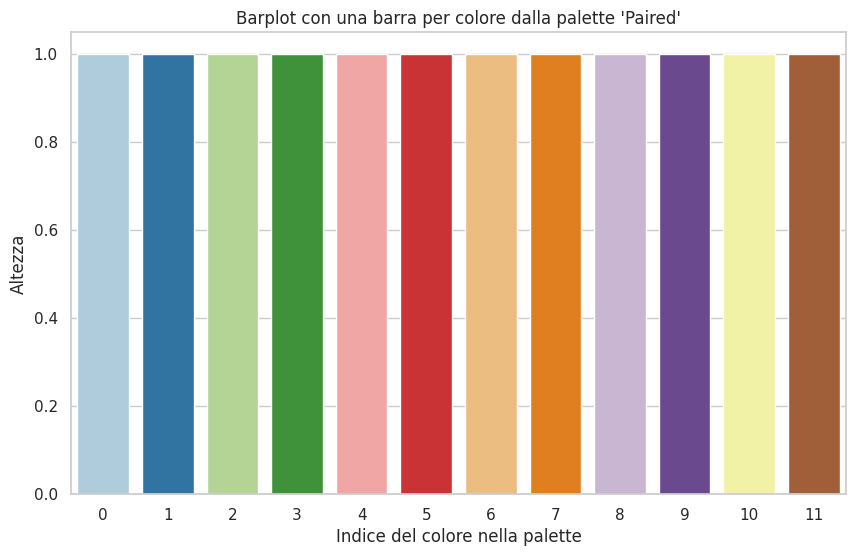

In [ ]:
palette = sns.color_palette("Paired")
num_colors = len(palette)
heights = np.ones(num_colors)

indices = np.arange(num_colors)

plt.figure(figsize=(10, 6))
sns.barplot(x=indices, y=heights, palette=palette)

plt.title("Barplot con una barra per colore dalla palette 'Paired'")
plt.xlabel("Indice del colore nella palette")
plt.ylabel("Altezza")

# Mostra il grafico
plt.show()

In [121]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Paired")
svqe_noiseless_color = palette[1]
qaoa_noiseless_color = palette[3]
exact_color = palette[5]
svqe_noisy_color = palette[0]
qaoa_noisy_color = palette[2]


qaua_color = "blue"
svqe_color = "green"
exact_color = "red"

### Noiseless plot

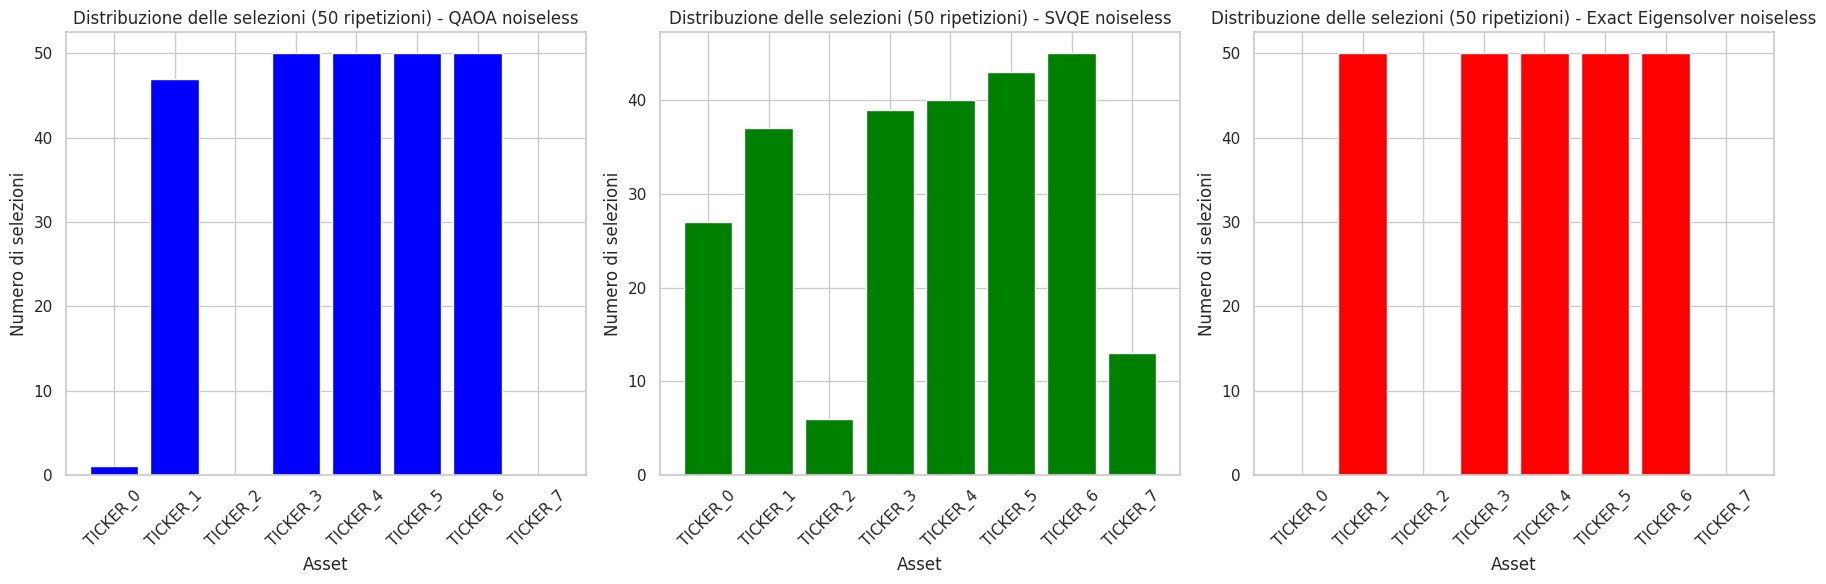

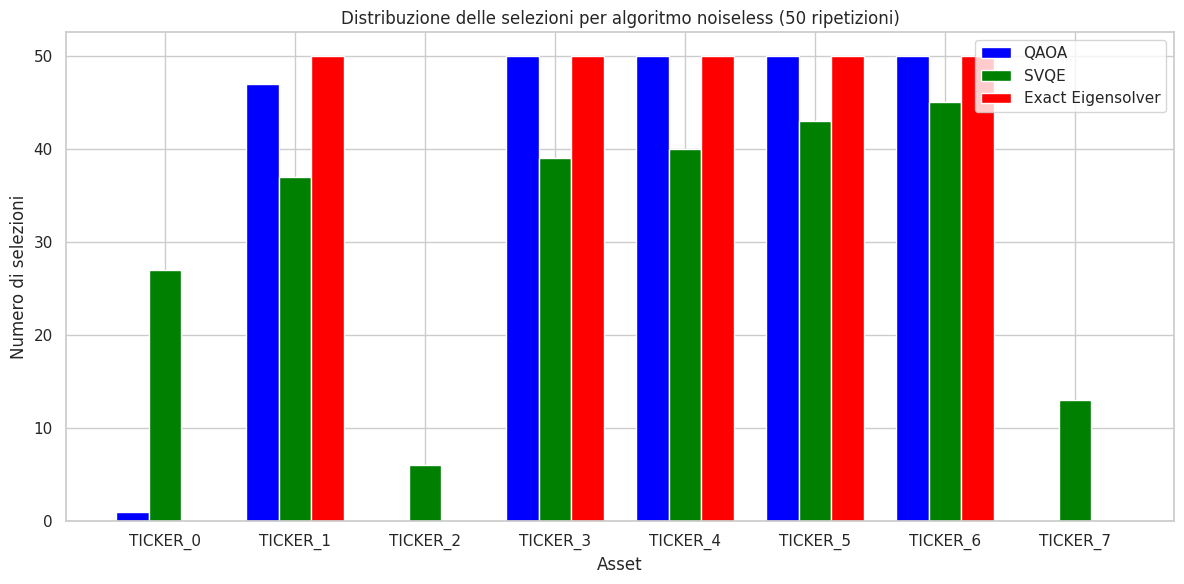

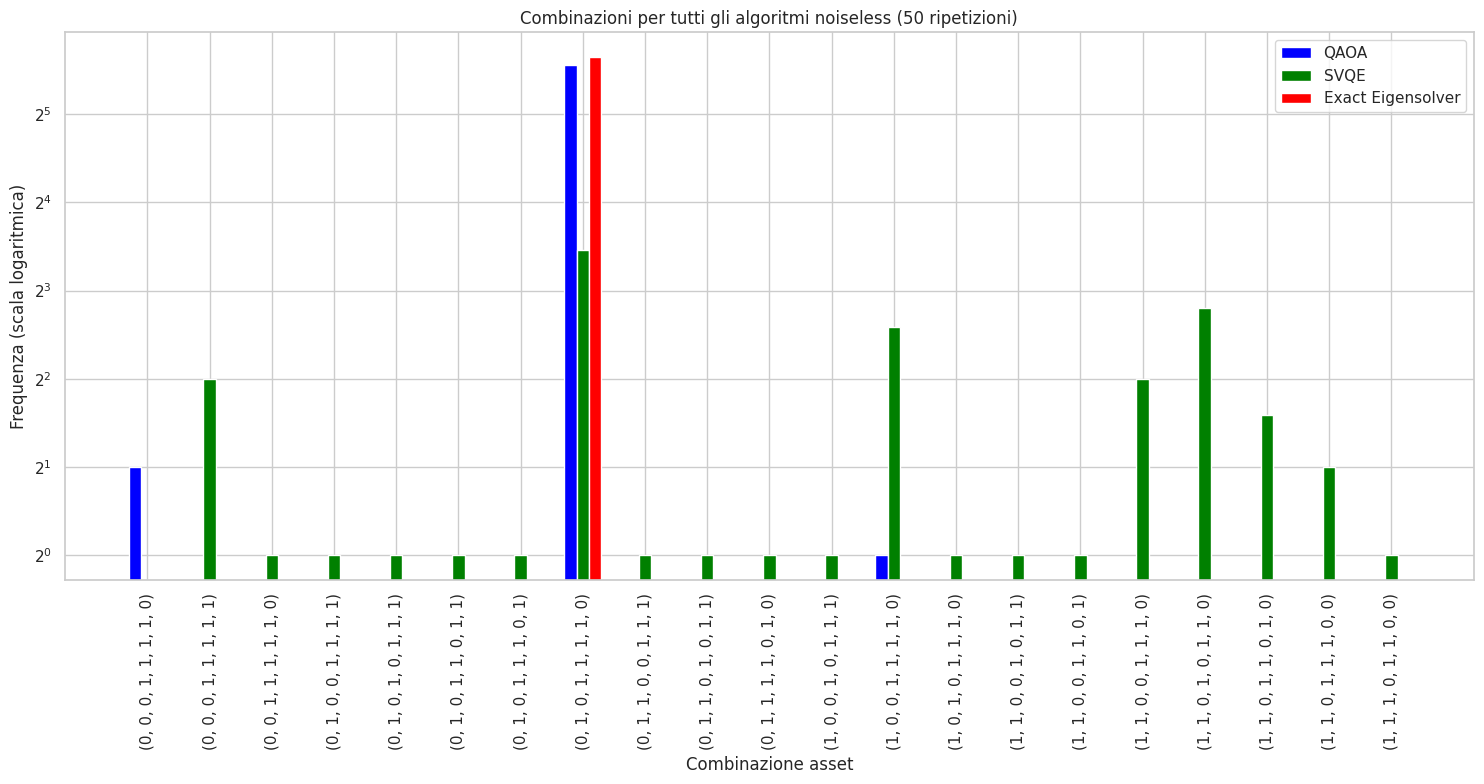

In [122]:
## Noiseless
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per QAOA noiseless
axs[0].bar(tickers, selection_counts_qaoa, color=qaua_color)
axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noiseless")
axs[0].set_xlabel("Asset")
axs[0].set_ylabel("Numero di selezioni")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Grafico per SVQE noiseless
axs[1].bar(tickers, selection_counts_svqe, color=svqe_color)
axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noiseless")
axs[1].set_xlabel("Asset")
axs[1].set_ylabel("Numero di selezioni")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Grafico per Exact Eigensolver
axs[2].bar(tickers, selection_counts_exact_eigensolver, color=exact_color)
axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver noiseless")
axs[2].set_xlabel("Asset")
axs[2].set_ylabel("Numero di selezioni")
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Grafico delle selezioni
width = 0.25
x = np.arange(len(tickers))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa, width, color=qaua_color, label='QAOA')
plt.bar(x, selection_counts_svqe, width, color=svqe_color, label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

plt.title(f"Distribuzione delle selezioni per algoritmo noiseless ({n_repeats} ripetizioni)")
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, tickers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Grafico combinazioni
n_combinations = len(filtered_combinations)
indice = np.arange(n_combinations)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))

# Barre per QAOA
plt.bar(indice - larghezza, filtered_frequencies_qaoa, larghezza, color=qaua_color, label='QAOA')
# Barre per SVQE
plt.bar(indice, filtered_frequencies_svqe, larghezza, color=svqe_color, label='SVQE')
# Barre per Exact Eigensolver
plt.bar(indice + larghezza, filtered_frequencies_exact, larghezza, color=exact_color, label='Exact Eigensolver')

plt.yscale('log', base=2)
plt.title(f"Combinazioni per tutti gli algoritmi noiseless ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

### Noiseless plot (seaborn)

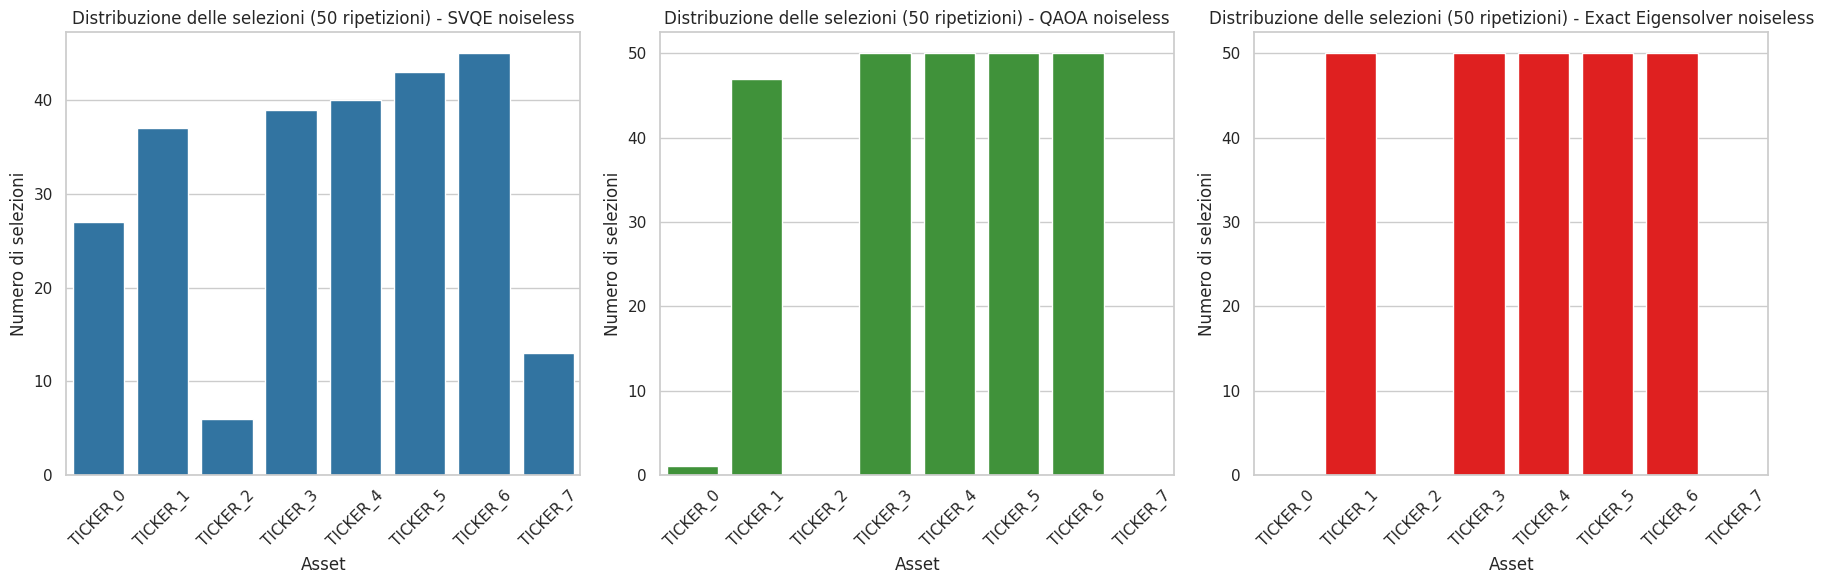

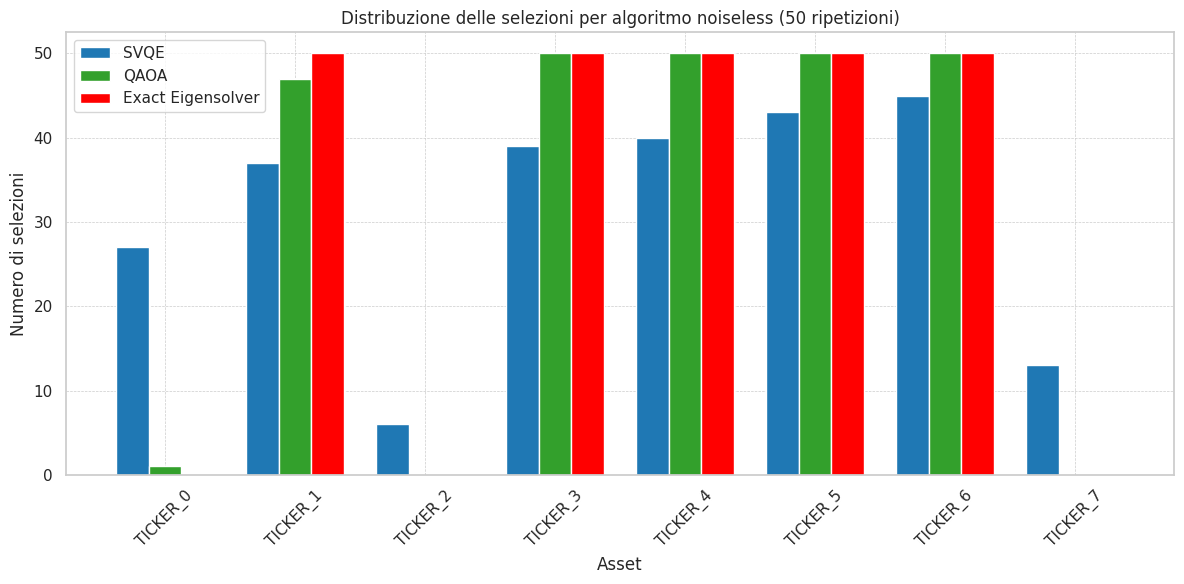

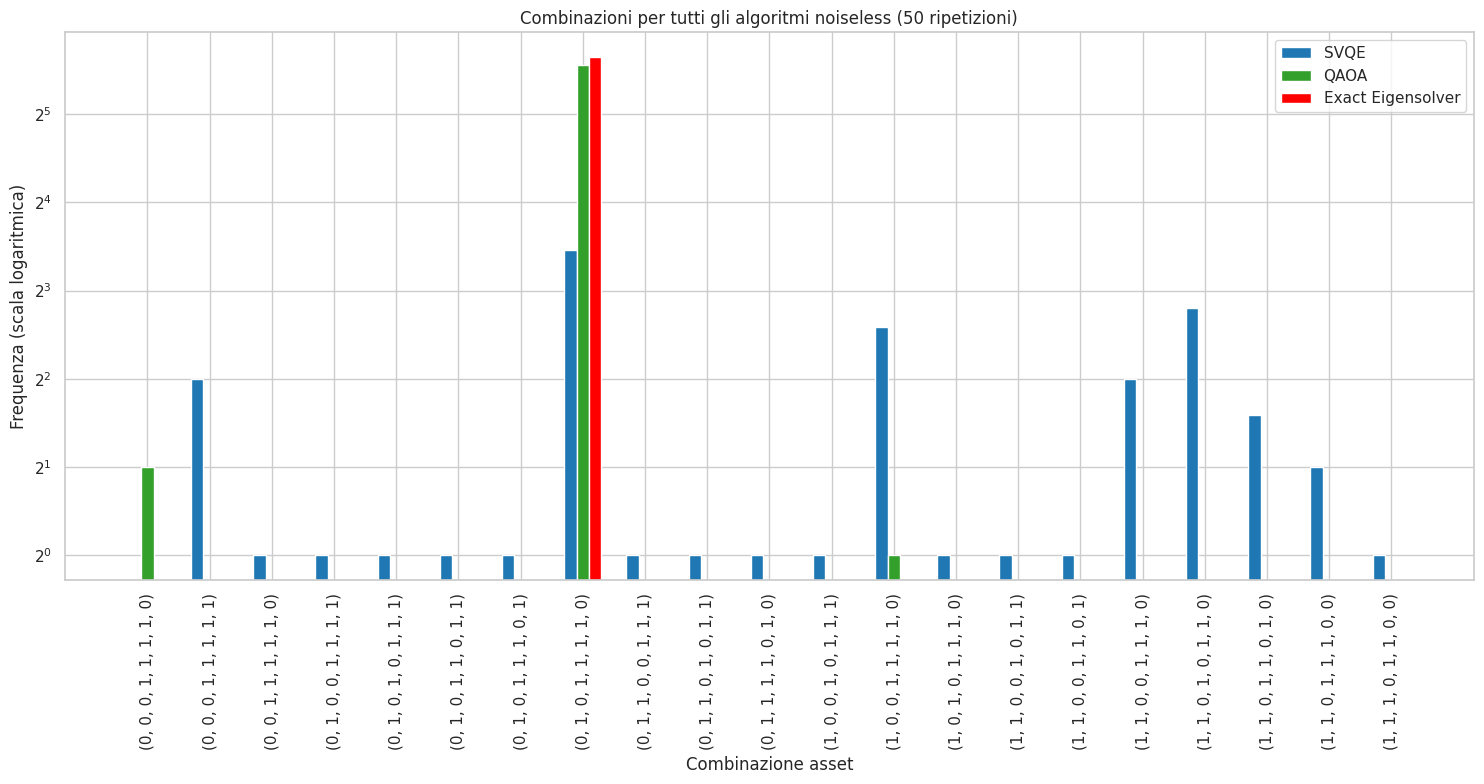

In [123]:
## Noiseless
def plot_noiseless():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # SVQE noiseless
    sns.barplot(x=tickers, y=selection_counts_svqe, ax=axs[0], color=svqe_noiseless_color)
    axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noiseless")
    axs[0].set_xlabel("Asset")
    axs[0].set_ylabel("Numero di selezioni")
    axs[0].tick_params(axis='x', rotation=45)
    
    # QAOA noiseless
    sns.barplot(x=tickers, y=selection_counts_qaoa, ax=axs[1], color=qaoa_noiseless_color)
    axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noiseless")
    axs[1].set_xlabel("Asset")
    axs[1].set_ylabel("Numero di selezioni")
    axs[1].tick_params(axis='x', rotation=45)

    # Exact Eigensolver
    sns.barplot(x=tickers, y=selection_counts_exact_eigensolver, ax=axs[2], color=exact_color)
    axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver noiseless")
    axs[2].set_xlabel("Asset")
    axs[2].set_ylabel("Numero di selezioni")
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Grafico aggregato delle selezioni noiseless
def plot_aggregate():
    width = 0.25
    x = np.arange(len(tickers))

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, selection_counts_svqe, width, color=svqe_noiseless_color, label='SVQE')
    plt.bar(x, selection_counts_qaoa, width, color=qaoa_noiseless_color, label='QAOA')
    plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

    plt.title(f"Distribuzione delle selezioni per algoritmo noiseless ({n_repeats} ripetizioni)")
    plt.xlabel('Asset')
    plt.ylabel('Numero di selezioni')
    plt.xticks(x, tickers, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Grafico combinazioni noiseless
def plot_combinations():
    n_combinations = len(filtered_combinations)
    indice = np.arange(n_combinations)
    larghezza = 0.2  # Larghezza delle barre

    plt.figure(figsize=(15, 8))

    # Barre per SVQE
    plt.bar(indice - larghezza, filtered_frequencies_svqe, larghezza, color=svqe_noiseless_color, label='SVQE')
    # Barre per QAOA
    plt.bar(indice, filtered_frequencies_qaoa, larghezza, color=qaoa_noiseless_color, label='QAOA')
    # Barre per Exact Eigensolver
    plt.bar(indice + larghezza, filtered_frequencies_exact, larghezza, color=exact_color, label='Exact Eigensolver')

    plt.yscale('log', base=2)
    plt.title(f"Combinazioni per tutti gli algoritmi noiseless ({n_repeats} ripetizioni)")
    plt.xlabel("Combinazione asset")
    plt.ylabel("Frequenza (scala logaritmica)")
    plt.xticks(indice, [str(comb) for comb in filtered_combinations], rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Chiamata alle funzioni
plot_noiseless()
plot_aggregate()
plot_combinations()

### Noisy plot

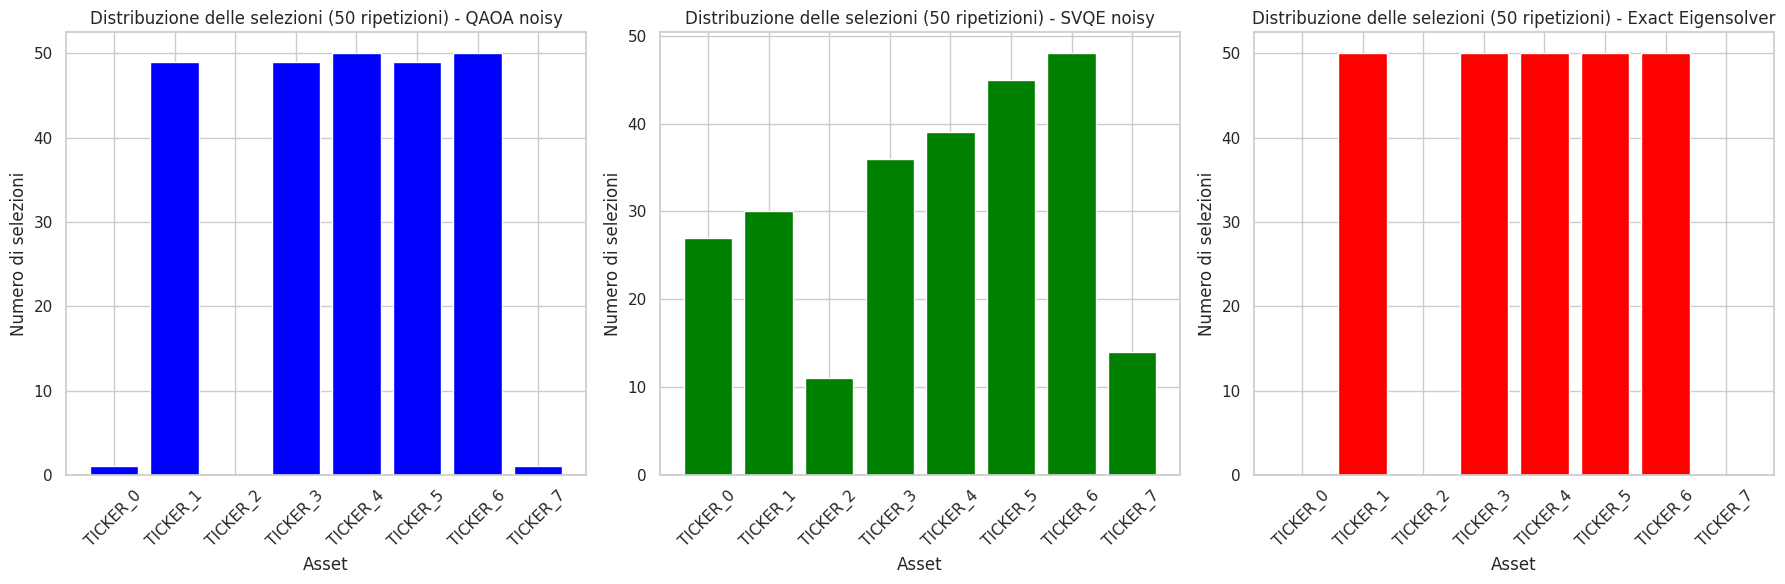

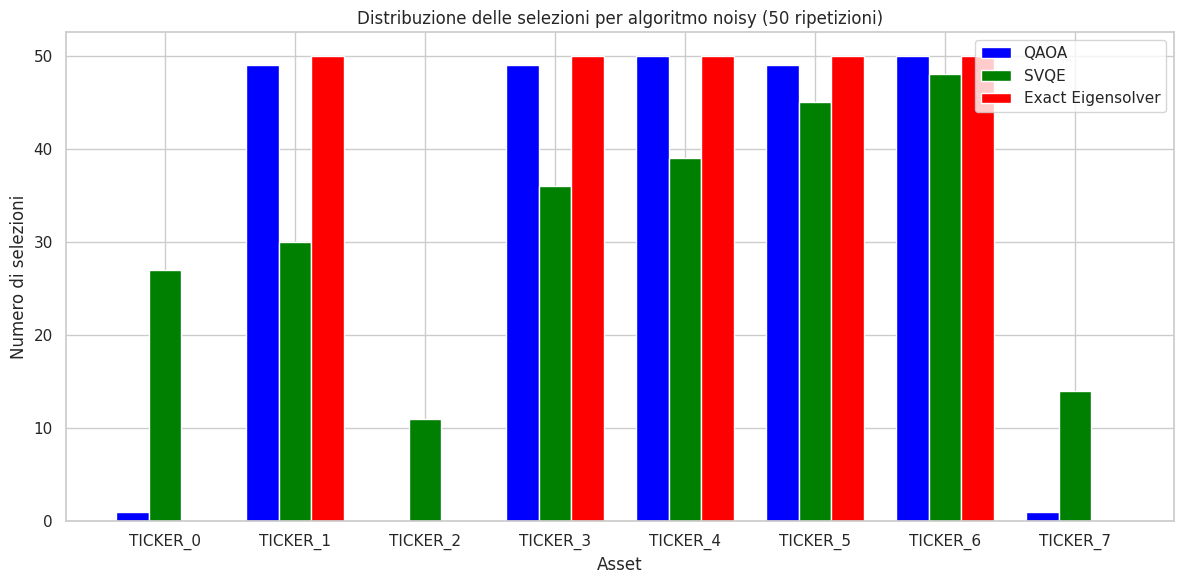

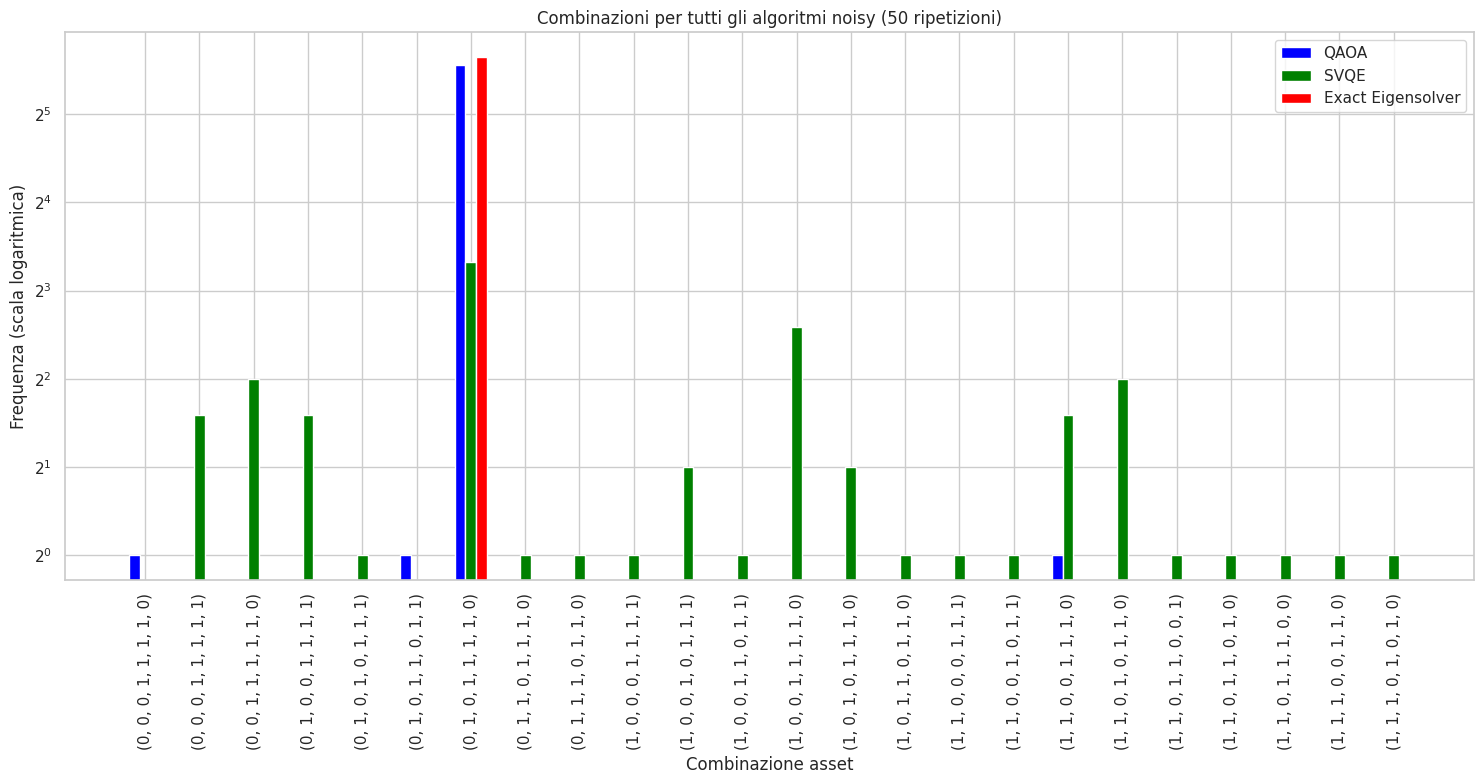

In [124]:
## Noisy
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per QAOA noisy
axs[0].bar(tickers, selection_counts_qaoa_noisy, color=qaua_color)
axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noisy")
axs[0].set_xlabel("Asset")
axs[0].set_ylabel("Numero di selezioni")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Grafico per SVQE noisy
axs[1].bar(tickers, selection_counts_svqe_noisy, color=svqe_color)
axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noisy")
axs[1].set_xlabel("Asset")
axs[1].set_ylabel("Numero di selezioni")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Grafico per Exact Eigensolver
axs[2].bar(tickers, selection_counts_exact_eigensolver, color=exact_color)
axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver")
axs[2].set_xlabel("Asset")
axs[2].set_ylabel("Numero di selezioni")
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Grafico delle selezioni
width = 0.25
x = np.arange(len(tickers))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa_noisy, width, color=qaua_color, label='QAOA')
plt.bar(x, selection_counts_svqe_noisy, width, color=svqe_color, label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

plt.title(f"Distribuzione delle selezioni per algoritmo noisy ({n_repeats} ripetizioni)")
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, tickers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Grafico combinazioni
n_combinations_noisy = len(filtered_combinations_noisy)
indice = np.arange(n_combinations_noisy)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))

# Barre per QAOA
plt.bar(indice - larghezza, filtered_frequencies_qaoa_noisy, larghezza, color=qaua_color, label='QAOA')
# Barre per SVQE
plt.bar(indice, filtered_frequencies_svqe_noisy, larghezza, color=svqe_color, label='SVQE')
# Barre per Exact Eigensolver
plt.bar(indice + larghezza, filtered_frequencies_exact_x_noise, larghezza, color=exact_color, label='Exact Eigensolver')

plt.yscale('log', base=2)
plt.title(f"Combinazioni per tutti gli algoritmi noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations_noisy], rotation=90)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Noisy plot (seaborn)

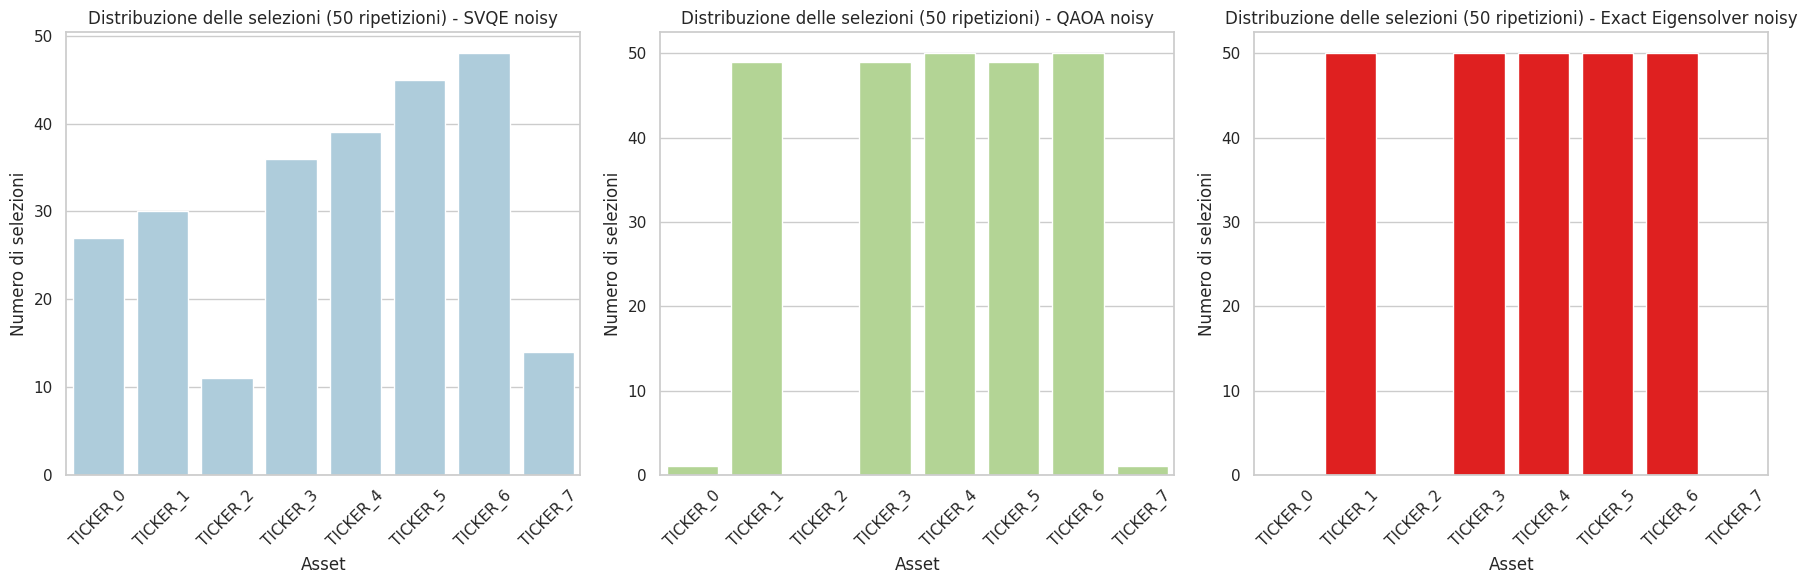

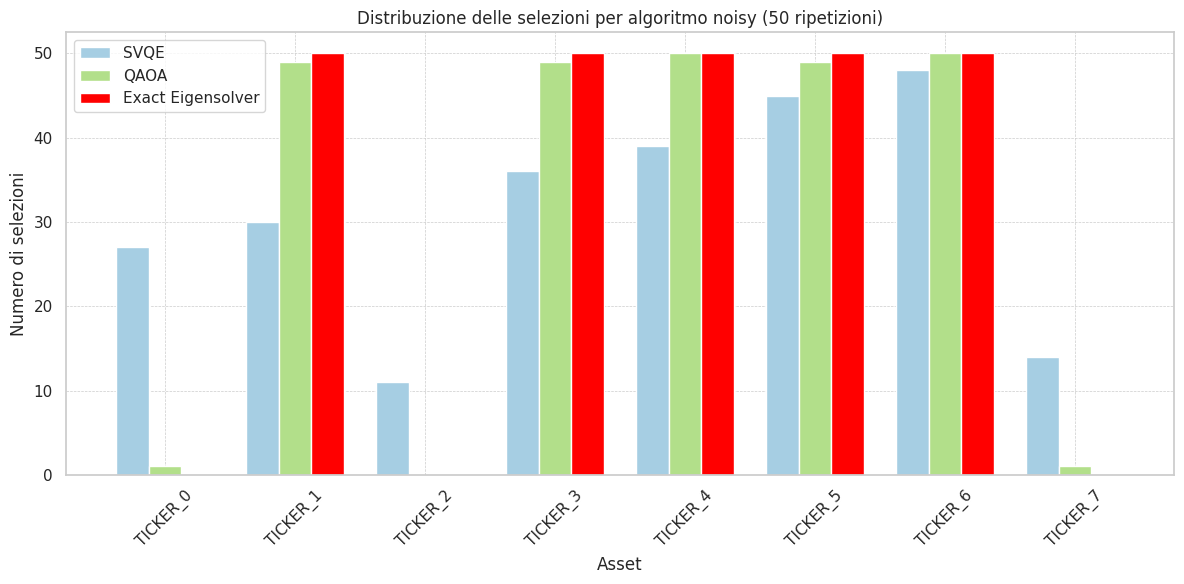

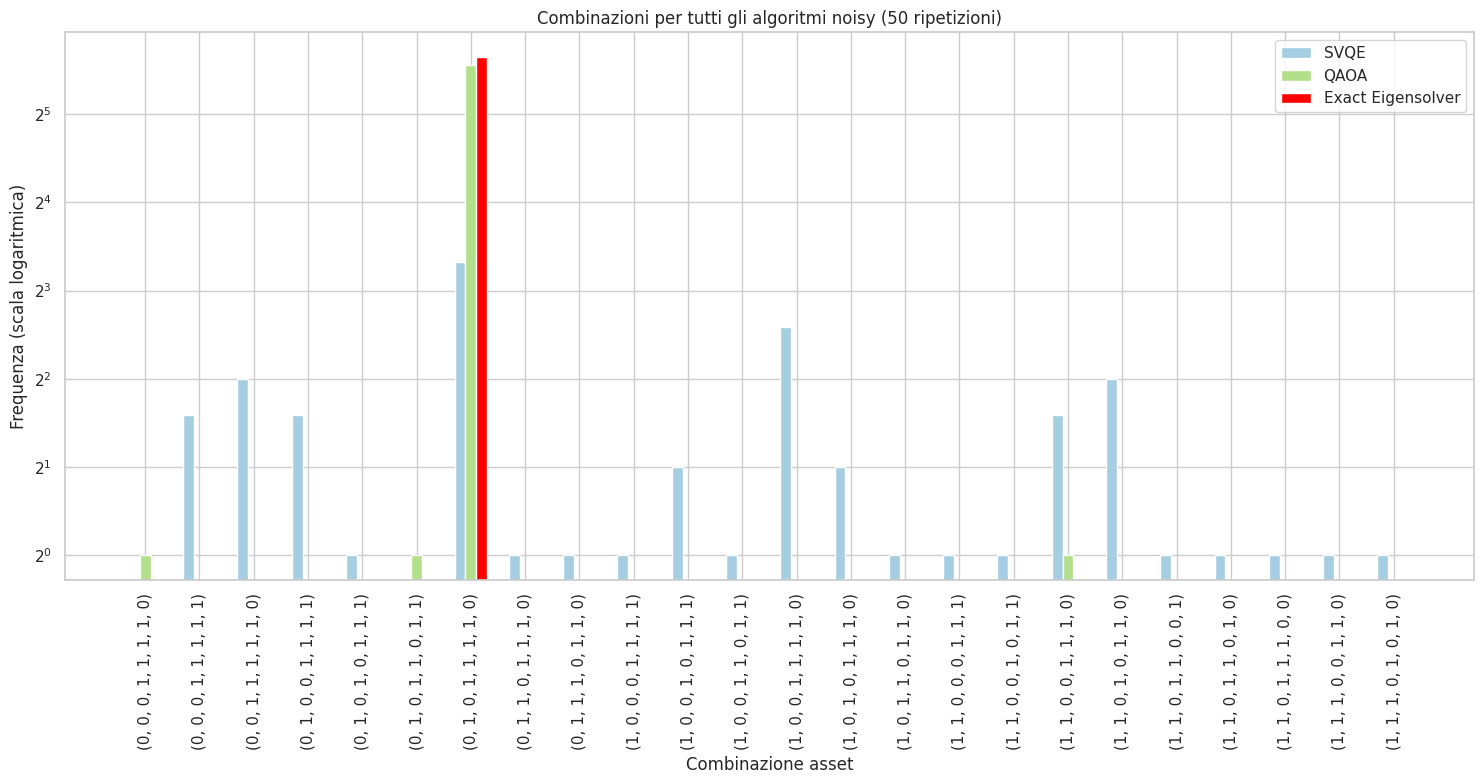

In [125]:
## Noisy
def plot_noisy():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # SVQE noisy
    sns.barplot(x=tickers, y=selection_counts_svqe_noisy, ax=axs[0], color=svqe_noisy_color)
    axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noisy")
    axs[0].set_xlabel("Asset")
    axs[0].set_ylabel("Numero di selezioni")
    axs[0].tick_params(axis='x', rotation=45)
    
    
    # QAOA noisy
    sns.barplot(x=tickers, y=selection_counts_qaoa_noisy, ax=axs[1], color=qaoa_noisy_color)
    axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noisy")
    axs[1].set_xlabel("Asset")
    axs[1].set_ylabel("Numero di selezioni")
    axs[1].tick_params(axis='x', rotation=45)


    # Exact Eigensolver
    sns.barplot(x=tickers, y=selection_counts_exact_eigensolver, ax=axs[2], color=exact_color)
    axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver noisy")
    axs[2].set_xlabel("Asset")
    axs[2].set_ylabel("Numero di selezioni")
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Grafico aggregato delle selezioni noisy
def plot_aggregate_noisy():
    width = 0.25
    x = np.arange(len(tickers))

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, selection_counts_svqe_noisy, width, color=svqe_noisy_color, label='SVQE')
    plt.bar(x, selection_counts_qaoa_noisy, width, color=qaoa_noisy_color, label='QAOA')
    plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

    plt.title(f"Distribuzione delle selezioni per algoritmo noisy ({n_repeats} ripetizioni)")
    plt.xlabel('Asset')
    plt.ylabel('Numero di selezioni')
    plt.xticks(x, tickers, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Grafico combinazioni noisy
def plot_combinations_noisy():
    n_combinations_noisy = len(filtered_combinations_noisy)
    indice = np.arange(n_combinations_noisy)
    larghezza = 0.2  # Larghezza delle barre

    plt.figure(figsize=(15, 8))

    # Barre per SVQE
    plt.bar(indice - larghezza, filtered_frequencies_svqe_noisy, larghezza, color=svqe_noisy_color, label='SVQE')
    # Barre per QAOA
    plt.bar(indice, filtered_frequencies_qaoa_noisy, larghezza, color=qaoa_noisy_color, label='QAOA')
    # Barre per Exact Eigensolver
    plt.bar(indice + larghezza, filtered_frequencies_exact_x_noise, larghezza, color=exact_color, label='Exact Eigensolver')

    plt.yscale('log', base=2)
    plt.title(f"Combinazioni per tutti gli algoritmi noisy ({n_repeats} ripetizioni)")
    plt.xlabel("Combinazione asset")
    plt.ylabel("Frequenza (scala logaritmica)")
    plt.xticks(indice, [str(comb) for comb in filtered_combinations_noisy], rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Chiamata alle funzioni
plot_noisy()
plot_aggregate_noisy()
plot_combinations_noisy()


### Confronto algoritmi (noiseless vs noisy)

In [126]:
# Estrazioni combinazioni interessate
all_combinations_vs = list(set(filtered_combinations_noisy).union(set(filtered_combinations)))

filtered_vqe_vs = []
filtered_vqe_noisy_vs = []
filtered_qaoa_vs = []
filtered_qaoa_noisy_vs = []

filtered_combinations_vqe_vs = []
filtered_combinations_qaoa_vs = []
filtered_frequencies_vqe_vs = []
filtered_frequencies_vqe_noisy_vs = []
filtered_frequencies_qaoa_vs = []
filtered_frequencies_qaoa_noisy_vs = []

# Filtra le combinazioni senza soluzioni
for comb in all_combinations_vs:
    fq_vqe = filtered_frequencies_svqe[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_qaoa = filtered_frequencies_qaoa[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_vqe_noisy = filtered_frequencies_svqe_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0
    fq_qaoa_noisy = filtered_frequencies_qaoa_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0

    if fq_vqe > 0 or fq_vqe_noisy > 0:
        filtered_combinations_vqe_vs.append(comb)
        filtered_frequencies_vqe_vs.append(fq_vqe)
        filtered_frequencies_vqe_noisy_vs.append(fq_vqe_noisy)
    
    if fq_qaoa > 0 or fq_qaoa_noisy > 0:
        filtered_combinations_qaoa_vs.append(comb)
        filtered_frequencies_qaoa_vs.append(fq_qaoa)
        filtered_frequencies_qaoa_noisy_vs.append(fq_qaoa_noisy)

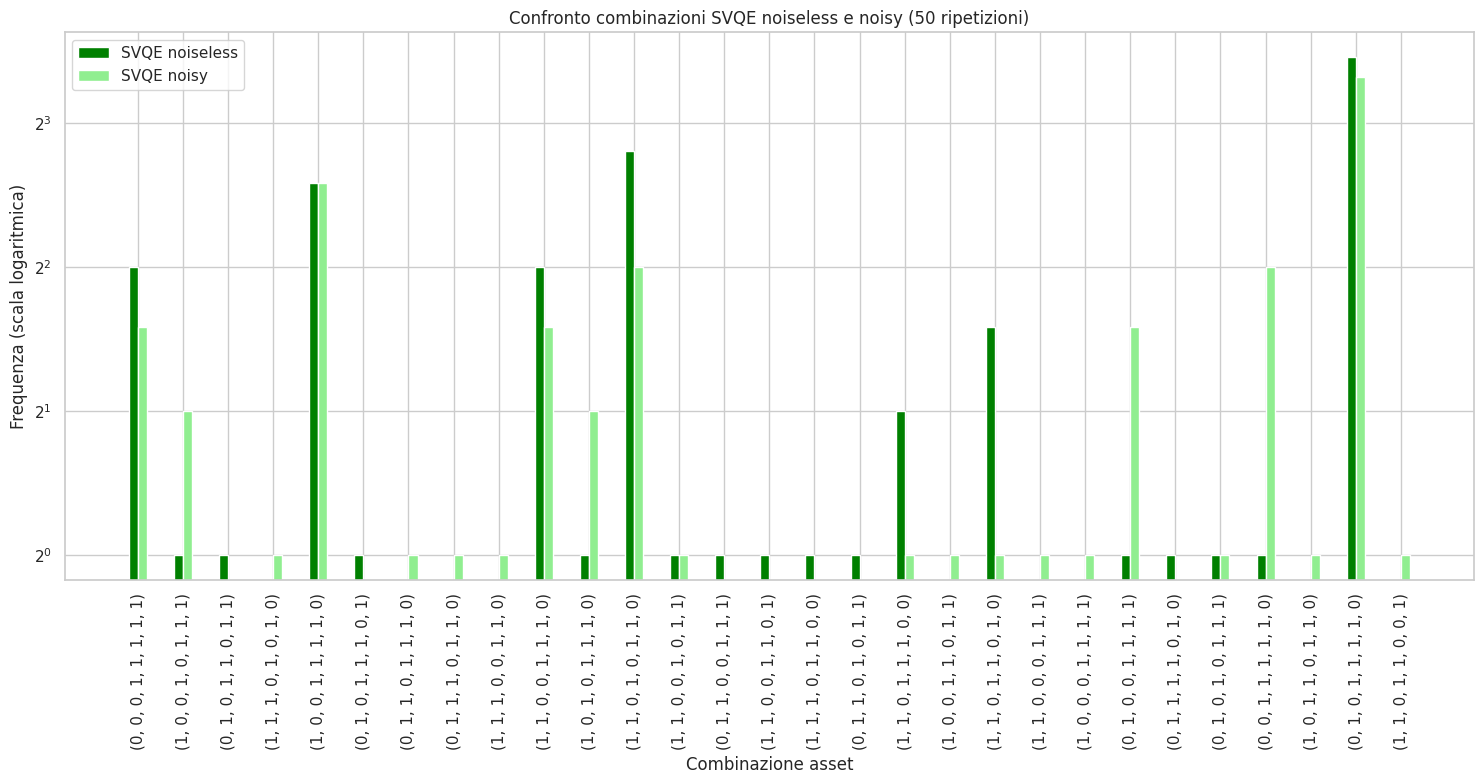

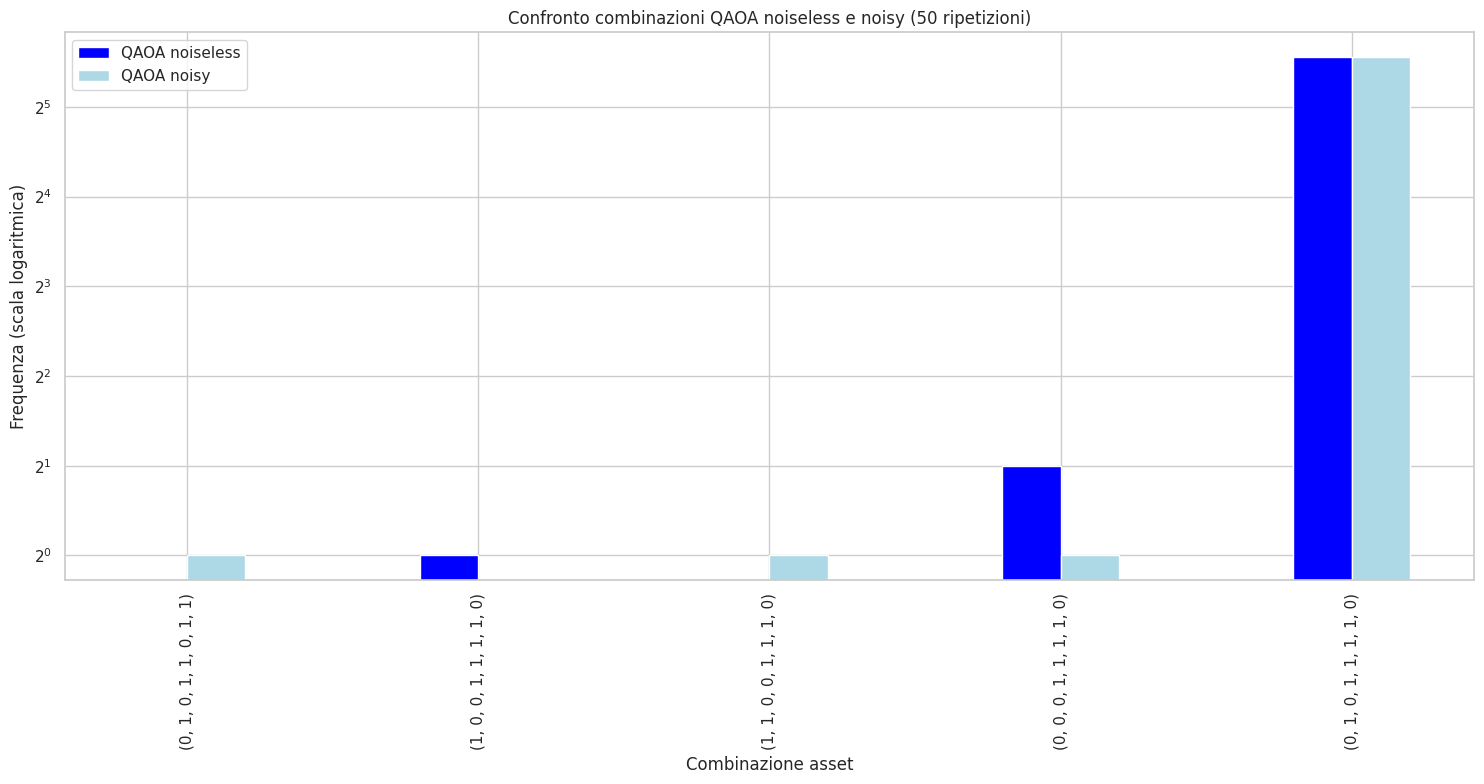

In [127]:
n_combinations_vs = len(filtered_combinations_vqe_vs)
indice = np.arange(n_combinations_vs)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))
# Confronto combinazioni VQE noiseless e VQE noisy
plt.bar(indice - larghezza/2, filtered_frequencies_vqe_vs, larghezza, color='green', label='SVQE noiseless')
plt.bar(indice + larghezza/2, filtered_frequencies_vqe_noisy_vs, larghezza, color='lightgreen', label='SVQE noisy')
plt.yscale('log', base=2)
plt.title(f"Confronto combinazioni SVQE noiseless e noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations_vqe_vs], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_combinations_vs = len(filtered_combinations_qaoa_vs)
indice = np.arange(n_combinations_vs)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))
# Confronto combinazioni QAOA noiseless e QAOA noisy
plt.bar(indice - larghezza/2, filtered_frequencies_qaoa_vs, larghezza, color='blue', label='QAOA noiseless')
plt.bar(indice + larghezza/2, filtered_frequencies_qaoa_noisy_vs, larghezza, color='lightblue', label='QAOA noisy')
plt.yscale('log', base=2)
plt.title(f"Confronto combinazioni QAOA noiseless e noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations_qaoa_vs], rotation=90)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Seaborn

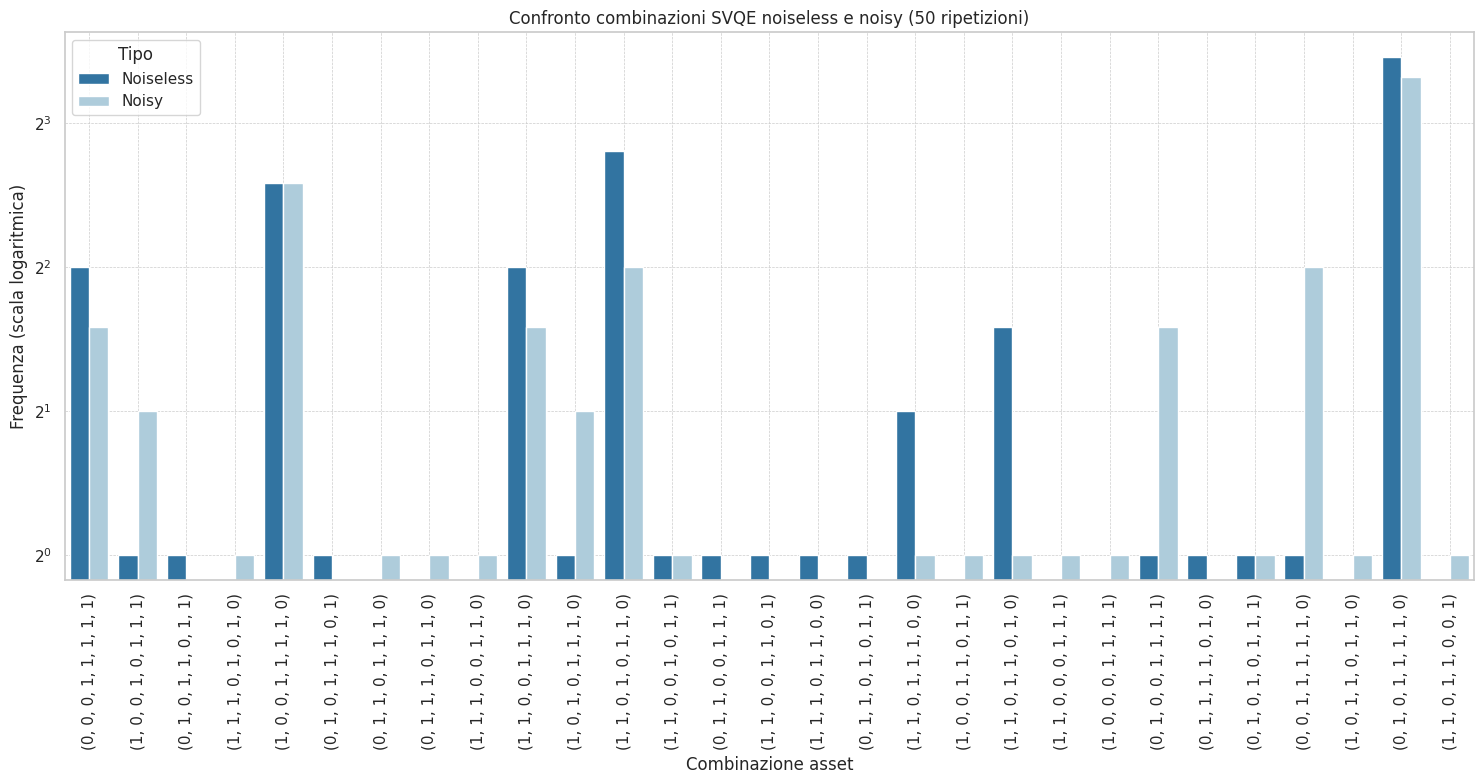

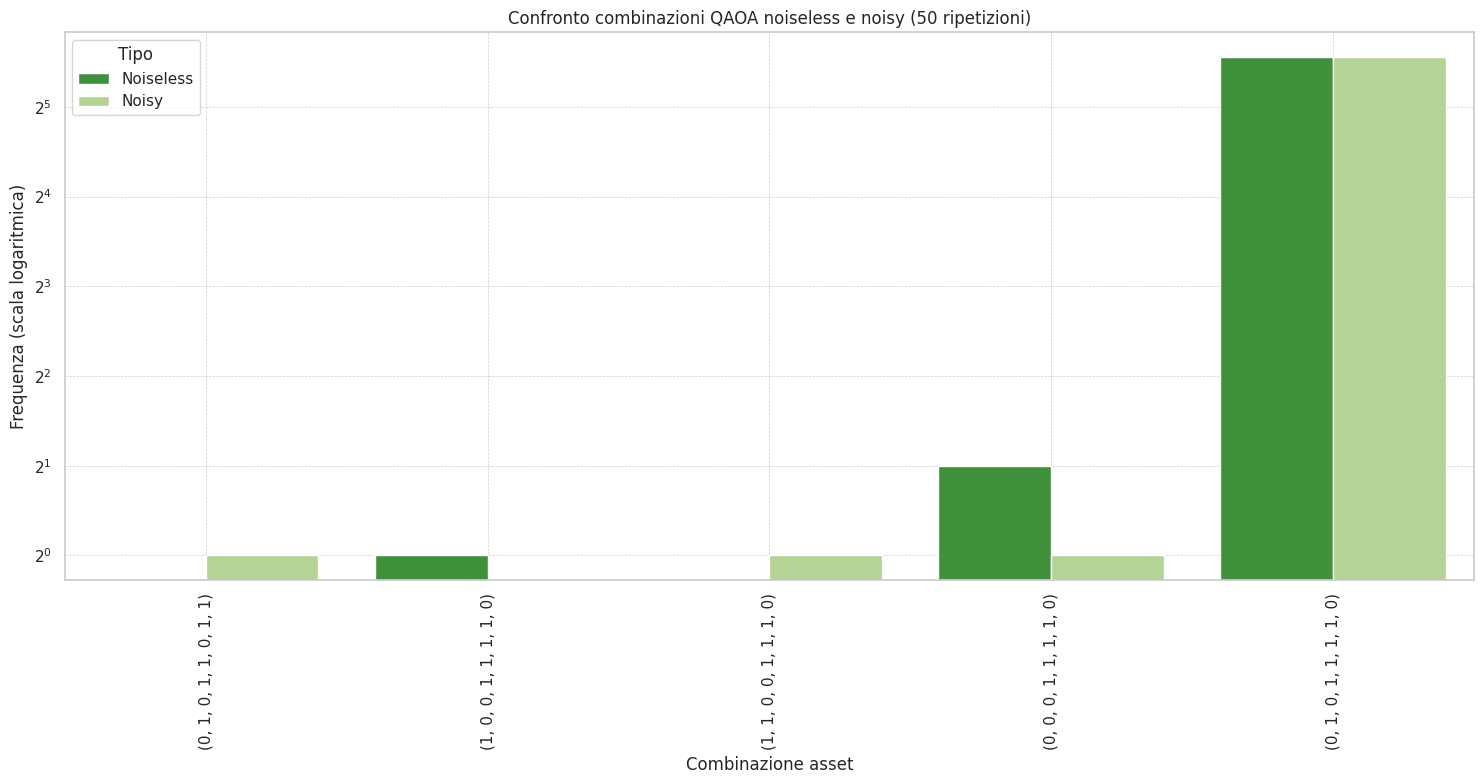

In [128]:
# Grafico combinazioni SVQE
n_combinations_vs = len(filtered_combinations_vqe_vs)
indice = np.arange(n_combinations_vs)
data_vqe = {
    "Combinazione": [str(comb) for comb in filtered_combinations_vqe_vs] * 2,
    "Frequenza": filtered_frequencies_vqe_vs + filtered_frequencies_vqe_noisy_vs,
    "Tipo": ["Noiseless"] * n_combinations_vs + ["Noisy"] * n_combinations_vs
}

plt.figure(figsize=(15, 8))
sns.barplot(
    data=data_vqe,
    x="Combinazione",
    y="Frequenza",
    hue="Tipo",
    palette={"Noiseless": svqe_noiseless_color, "Noisy": svqe_noisy_color}
)
plt.yscale('log', base=2)
plt.title(f"Confronto combinazioni SVQE noiseless e noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(rotation=90)
plt.legend(title="Tipo")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Grafico combinazioni QAOA
n_combinations_vs = len(filtered_combinations_qaoa_vs)
data_qaoa = {
    "Combinazione": [str(comb) for comb in filtered_combinations_qaoa_vs] * 2,
    "Frequenza": filtered_frequencies_qaoa_vs + filtered_frequencies_qaoa_noisy_vs,
    "Tipo": ["Noiseless"] * n_combinations_vs + ["Noisy"] * n_combinations_vs
}

plt.figure(figsize=(15, 8))
sns.barplot(
    data=data_qaoa,
    x="Combinazione",
    y="Frequenza",
    hue="Tipo",
    palette={"Noiseless": qaoa_noiseless_color, "Noisy": qaoa_noisy_color}
)
plt.yscale('log', base=2)
plt.title(f"Confronto combinazioni QAOA noiseless e noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(rotation=90)
plt.legend(title="Tipo")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Analisi del rischio vs ritorno atteso per diversi algoritmi

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo una serie di valori di rischio (`risks`) utilizzando `np.linspace` per generare 20 valori equidistanti tra 0 e 1.
2. Calcoliamo i valori ottimali per ciascun valore di rischio utilizzando i tre algoritmi di ottimizzazione del portafoglio (`QAOA`, `SVQE`, `Exact Eigensolver`):
   - **QAOA**:
     - Inizializziamo una lista vuota (`values_per_risk_qaoa`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `qaoa` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **SVQE**:
     - Inizializziamo una lista vuota (`values_per_risk_svqe`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `svqe` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **Exact Eigensolver**:
     - Inizializziamo una lista vuota (`values_exact_eigensolver`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `exact_eigensolver` e memorizziamo il valore ottimale (`result.fval`) nella lista.
3. Creiamo un grafico per visualizzare la relazione tra il fattore di rischio e il valore ottimale per ciascun algoritmo:
   - Utilizziamo `plt.plot` per tracciare i valori ottimali in funzione del fattore di rischio per `QAOA`, `SVQE` e `Exact Eigensolver`, con diversi marker e colori per ciascun algoritmo.
   - Impostiamo il titolo del grafico a "Rischio vs ritorno atteso per diversi algoritmi".
   - Etichettiamo gli assi x e y rispettivamente come "Fattore di rischio" e "Valore ottimale".
   - Aggiungiamo una griglia e una legenda per migliorare la leggibilità del grafico.
   - Utilizziamo `plt.tight_layout` per ottimizzare il layout del grafico e `plt.show` per visualizzarlo.

## Stampa delle informazioni del modello

In [129]:
def print_backend_info(backend):
    print("\n=== Informazioni sul Backend ===\n")
    print(f"Nome: {backend.name}")
    print(f"Descrizione: {backend.description}")
    print(f"Versione: {backend.version}")
    print(f"Numero di Qubit: {backend.num_qubits}")
    config = backend.configuration()
    print(f"Istruzioni supportate:")
    for instruction in config.supported_instructions:
        print(f"- {instruction}")
    print()
    

def print_noise_model_info(noise_model):
    print("\n=== Informazioni sul modello di rumore ===\n")
    print(noise_model)
    # TODO aggiungere informazioni sull'errore sul singolo qubit

# print_backend_info(backend)
# print_noise_model_info(noise_model)

### Calcolo dei dati

In [132]:
risks = np.linspace(0, 1, 20)

# Risultati per QAOA
values_per_risk_qaoa = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = qaoa.solve(qp)
    values_per_risk_qaoa.append(result.fval)

# Risultati per SVQE
values_per_risk_svqe = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = svqe.solve(qp)
    values_per_risk_svqe.append(result.fval)

# Risultati per Exact Eigensolver
values_exact_eigensolver = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values_exact_eigensolver.append(result.fval)

### Plot mlp

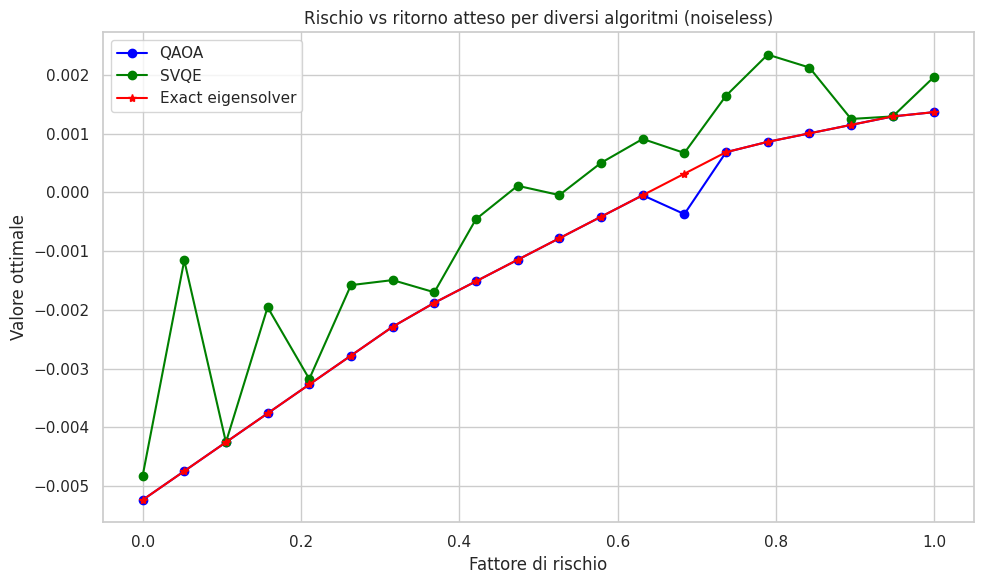

In [133]:
# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plot per QAOA
plt.plot(risks, values_per_risk_qaoa, marker='o', linestyle='-', color=qaua_color, label='QAOA')

# Plot per SVQE
plt.plot(risks, values_per_risk_svqe, marker='o', linestyle='-', color=svqe_color, label='SVQE')

# Plot per Exact Eigensolver
plt.plot(risks, values_exact_eigensolver, marker='*', linestyle='-', color=exact_color, label='Exact eigensolver')

plt.title("Rischio vs ritorno atteso per diversi algoritmi (noiseless)")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()